# House Prices Kaggle

In [1]:
#Import libraries and set configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import category_encoders as ce
import cupy as cp
import warnings
import logging
import time
import GPUtil
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_log_error, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
pd.set_option('display.max_columns', 85)
pd.set_option('isplay.max_rows', 85)

In [2]:
#Load data set
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# # Assign 'train' label to source column in training data 
train_df['Source'] = 'Train'

# Assign 'test' label to source column in testing data
test_df['Source'] = 'Test'

# Concatenate training and testing data
df1 = pd.concat([train_df, test_df])

In [4]:
# Information of datset
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [5]:
# Convert MSSubClass to categorical variable
df1['MSSubClass'] = df1['MSSubClass'].astype('object')


Some columns can take the value 'NA'. We'll replace these values with 'None' since they can be identified as null values. 

In [6]:
# Select the columns that can take the value 'NA'
columns_NA = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
              'FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 
              'Fence', 'MiscFeature', 'MasVnrType']

# Replace the null values with 'None' in columns that have the value 'NA'
for column in columns_NA:
    df1[column] = df1[column].fillna('None')

### EDA RAW DATA 

In this part we'll work only with train.csv file

In [7]:
# Create a copy of the train dataset
raw_train_df = df1[df1['Source'] == 'Train'].copy()

# Display statistical summary of raw_train_df
raw_train_df.loc[:, raw_train_df.columns != 'Id'].describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1201.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082     6.099315     5.575342  1971.267808   
std      24.284752    9981.264932     1.382997     1.112799    30.202904   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      59.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      69.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      80.000000   11601.500000     7.000000     6.000000  2000.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   1460.000000  1452.000000  1460.000000  1460.000000  1460.000000   
mean    1984.865753   103.685262   443.639726    46.549315   567.240411   
std       20.645407   181.066207   456.098091   161.319273   441.866955   
min     1950.000000     0.000000     0.000000     0.000000     0.000000   
25%     1967.000000     0.000000     0.000000     0.000000   223.000000   
50%     1994.000000     0.000000   383.500000     0.000000   477.500000   
75%     2004.000000   166.000000   712.250000     0.000000   808.000000   
max     2010.000000  1600.000000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   
mean   1057.429452  1162.626712   346.992466      5.844521  1515.463699   
std     438.705324   386.587738   436.528436     48.623081   525.480383   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.750000   882.000000     0.000000      0.000000  1129.500000   
50%     991.500000  1087.000000     0.000000      0.000000  1464.000000   
75%    1298.250000  1391.250000   728.000000      0.000000  1776.750000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1460.000000   1460.000000  1460.000000  1460.000000   1460.000000   
mean       0.425342      0.057534     1.565068     0.382877      2.866438   
std        0.518911      0.238753     0.550916     0.502885      0.815778   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     3.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   1460.000000   1460.000000  1460.000000  1379.000000  1460.000000   
mean       1.046575      6.517808     0.613014  1978.506164     1.767123   
std        0.220338      1.625393     0.644666    24.689725     0.747315   
min        0.000000      2.000000     0.000000  1900.000000     0.000000   
25%        1.000000      5.000000     0.000000  1961.000000     1.000000   
50%        1.000000      6.000000     1.000000  1980.000000     2.000000   
75%        1.000000      7.000000     1.000000  2002.000000     2.000000   
max        3.000000     14.000000     3.000000  2010.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000

In [8]:
# Create a function to compute some statistics for a given column
def analyze_housing_data(df, column_name):
    
    # Group by the specified column and calculate the count and various percentiles of sale price
    grouped = df.groupby(column_name)['SalePrice'].agg(['count', 'mean', 'min', 
                                                        lambda x: x.quantile(0.01), 
                                                        lambda x: x.quantile(0.10), 
                                                        lambda x: x.quantile(0.25), 
                                                        lambda x: x.quantile(0.50), 
                                                        lambda x: x.quantile(0.75),
                                                        lambda x: x.quantile(0.90), 
                                                        lambda x: x.quantile(0.99), 
                                                        'max']).reset_index()
    
    # Rename the columns
    grouped = grouped.rename(columns={'count': 'num_houses',
                                      'mean': 'avg_sale_price',
                                      'min': 'min_price', 
                                      '<lambda_0>': 'percentile1_price',
                                      '<lambda_1>': 'percentile10_price',
                                      '<lambda_2>': 'percentile25_price',
                                      '<lambda_3>': 'median_price',
                                      '<lambda_4>': 'percentile75_price',
                                      '<lambda_5>': 'percentile90_price',
                                      '<lambda_6>': 'percentile99_price',
                                      'max': 'max_price' 
                                      })
    
    # Sort the resulting DataFrame by avg_sale_price in descending order
    grouped = grouped.sort_values(by='avg_sale_price', ascending=False).reset_index(drop=True)
    
    return grouped



In [9]:
# Select column to analize
column_analysis = ['Neighborhood',  'SaleType', 'Foundation', 'MSSubClass', 
                     'GarageType', 'YrSold', 'MoSold', 'LotConfig']
# Show analize for each column
for col in column_analysis:
    print('Variable analysis:', col)
    display(analyze_housing_data(raw_train_df, col))
    print('--------------------------------------------------------')

Variable analysis: Neighborhood


Neighborhood  num_houses  avg_sale_price  min_price  percentile1_price  \
0       NoRidge          41   335295.317073   190000.0          202400.00   
1       NridgHt          77   316270.623377   154000.0          167490.00   
2       StoneBr          25   310499.000000   170000.0          172400.00   
3        Timber          38   242247.447368   137500.0          145825.00   
4       Veenker          11   238772.727273   162500.0          162750.00   
5       Somerst          86   225379.837209   144152.0          145722.80   
6       ClearCr          28   212565.428571   130000.0          131196.64   
7       Crawfor          51   210624.725490    90350.0           93425.00   
8       CollgCr         150   197965.773333   110000.0          117155.00   
9       Blmngtn          17   194870.882353   159895.0          159943.80   
10      Gilbert          79   192854.506329   141000.0          144120.00   
11       NWAmes          73   189050.068493    82500.0          120300.00   
12      SawyerW          59   186555.796610    76000.0           79480.00   
13      Mitchel          49   156270.122449    84500.0           88820.00   
14        NAmes         225   145847.080000    87500.0           90696.00   
15      NPkVill           9   142694.444444   127500.0          127540.00   
16        SWISU          25   142591.360000    60000.0           67440.00   
17      Blueste           2   137500.000000   124000.0          124270.00   
18       Sawyer          74   136793.135135    62383.0           75243.41   
19      OldTown         113   128225.300885    37900.0           53940.00   
20      Edwards         100   128219.700000    58500.0           59985.00   
21      BrkSide          58   124834.051724    39300.0           46539.00   
22       BrDale          16   104493.750000    83000.0           83360.00   
23       IDOTRR          37   100123.783784    34900.0           35047.96   
24      MeadowV          17    98576.470588    75000.0           75080.00   

    percentile10_price  percentile25_price  median_price  percentile75_price  \
0             250000.0           265000.00      301500.0           341000.00   
1             202500.0           253293.00      315000.0           374000.00   
2             188100.0           213500.00      278000.0           377426.00   
3             173500.0           186900.00      228475.0           286115.75   
4             165000.0           184250.00      218000.0           282000.00   
5             162250.0           177975.00      225500.0           252919.50   
6             151400.0           183750.00      200250.0           242225.00   
7             139000.0           159250.00      200624.0           239000.00   
8             132950.0           152958.75      197200.0           225725.00   
9             164424.0           174000.00      191000.0           213490.00   
10            167520.0           174000.00      181000.0           197200.00   
11            152000.0           165150.00      182900.0           205000.00   
12            119712.8           145500.00      179900.0           222500.00   
13            118600.0           131000.00      153500.0           171000.00   
14            110000.0           127500.00      140000.0           158000.00   
15            127900.0           140000.00      146000.0           148500.00   
16            107200.0           128000.00      139500.0           160000.00   
17            126700.0           130750.00      137500.0           144250.00   
18            110530.0           127250.00      135000.0           149462.50   
19             87000.0           105900.00      119000.0           140000.00   
20             82450.0           101500.00      121750.0           145225.00   
21             78600.0           100500.00      124300.0           141175.00   
22             86700.0            91000.00      106000.0           118000.00   
23             55000.0            81000.00      103000.0           120500.00   


--------------------------------------------------------
Variable analysis: SaleType


SaleType  num_houses  avg_sale_price  min_price  percentile1_price  \
0      New         122   274945.418033   113000.0          141470.00   
1      Con           2   269600.000000   215200.0          216288.00   
2      CWD           4   210600.000000   136000.0          136660.00   
3    ConLI           5   200390.000000   110000.0          110200.00   
4       WD        1267   173401.836622    34900.0           61912.78   
5      COD          43   143973.255814    60000.0           63528.00   
6    ConLw           5   143700.000000    60000.0           61400.00   
7    ConLD           9   138780.888889    79900.0           79988.00   
8      Oth           3   119850.000000    93500.0           93951.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            165215.0           194050.25      247453.0           341919.75   
1            226080.0           242400.00      269600.0           296800.00   
2            142600.0           152500.00      188750.0           246850.00   
3            112000.0           115000.00      125000.0           200000.00   
4            105000.0           128925.00      158000.0           202950.00   
5             98800.0           112000.00      139000.0           160500.00   
6             74000.0            95000.00      144000.0           207500.00   
7             80780.0            85000.00      140000.0           160000.00   
8             98010.0           104775.00      116050.0           133025.00   

   percentile90_price  percentile99_price  max_price  
0            422229.8           577399.08   611657.0  
1            313120.0           322912.00   324000.0  
2            296080.0           325618.00   328900.0  
3            351170.0           441872.00   451950.0  
4            262368.0           385425.00   755000.0  
5            190000.0           274400.00   287000.0  
6            210200.0           211820.00   212000.0  
7            205825.6           232197.76   235128.0  
8            143210.0           149321.00   150000.0

--------------------------------------------------------
Variable analysis: Foundation


Foundation  num_houses  avg_sale_price  min_price  percentile1_price  \
0      PConc         647   225230.442040    78000.0           91799.00   
1       Wood           3   185666.666667   143000.0          143420.00   
2      Stone           6   165959.166667   102776.0          103012.20   
3     CBlock         634   149805.714511    34900.0           60786.39   
4     BrkTil         146   132291.075342    37900.0           46750.00   
5       Slab          24   107365.625000    39300.0           42911.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            139000.0            173000.0      205000.0           262140.00   
1            147200.0            153500.0      164000.0           207000.00   
2            105138.0            109625.0      126500.0           233734.25   
3            100000.0            122125.0      141500.0           168000.00   
4             79250.0            102400.0      125250.0           151250.00   
5             80950.0             89375.0      104150.0           118884.50   

   percentile90_price  percentile99_price  max_price  
0            330607.2           547180.00   755000.0  
1            232800.0           248280.00   250000.0  
2            266239.5           266473.95   266500.0  
3            207320.0           313845.00   402861.0  
4            190475.0           311500.00   475000.0  
5            143685.9           191715.00   198500.0

--------------------------------------------------------
Variable analysis: MSSubClass


MSSubClass  num_houses  avg_sale_price  min_price  percentile1_price  \
0           60         299   239948.501672   129000.0           135000.0   
1          120          87   200779.080460    99500.0           121430.0   
2           75          16   192437.500000   101000.0           101450.0   
3           20         536   185224.811567    35311.0            75125.0   
4           80          58   169736.551724   107000.0           117260.0   
5           70          60   166772.416667    40000.0            62420.0   
6           40           4   156125.000000    79500.0            81105.0   
7           85          20   147810.000000   123000.0           124140.0   
8           50         144   143302.972222    37900.0            67317.0   
9          160          63   138647.380952    75000.0            79960.0   
10          90          52   133541.076923    82000.0            84805.0   
11         190          30   129613.333333    55000.0            62250.0   
12          45          12   108591.666667    76000.0            77210.0   
13         180          10   102300.000000    75500.0            75905.0   
14          30          69    95829.724638    34900.0            46528.0   

    percentile10_price  percentile25_price  median_price  percentile75_price  \
0             170700.0            185000.0      215200.0            268750.0   
1             138600.0            158050.0      192000.0            232000.0   
2             105000.0            125625.0      163500.0            219625.0   
3             115000.0            132500.0      159250.0            220000.0   
4             134600.0            147250.0      166500.0            179425.0   
5             107450.0            128000.0      156000.0            189500.0   
6              95550.0            119625.0      142500.0            179000.0   
7             129450.0            134350.0      140750.0            158375.0   
8              96800.0            114125.0      132000.0            159000.0   
9              88300.0            114000.0      146000.0            164850.0   
10             94150.0            118375.0      135980.0            145000.0   
11             89450.0            108875.0      128250.0            143750.0   
12             87000.0             94125.0      107500.0            122250.0   
13             79550.0             81875.0       88500.0            128000.0   
14             60800.0             81000.0       99900.0            110500.0   

    percentile90_price  percentile99_price  max_price  
0             335200.0           583774.34   755000.0  
1             276000.0           370822.84   392500.0  
2             310000.0           452500.00   475000.0  
3             288045.0           436500.00   611657.0  
4             191200.0           305100.00   345000.0  
5             239540.0           333081.00   359100.0  
6             227600.0           256760.00   260000.0  
7             171740.0           194681.00   198500.0  
8             206400.0           353308.00   410000.0  
9             175900.0           219470.00   239000.0  
10            169330.0           203087.00   206300.0  
11            163500.0           220554.50   228950.0  
12            134700.0           138916.00   139400.0  
13            145300.0           147730.00   148000.0  
14            120600.0           156700.00   163500.0

--------------------------------------------------------
Variable analysis: GarageType


GarageType  num_houses  avg_sale_price  min_price  percentile1_price  \
0    BuiltIn          88   254751.738636    91000.0           92740.00   
1     Attchd         870   202892.656322    60000.0           87380.00   
2    Basment          19   160570.684211    55993.0           60854.26   
3     2Types           6   151283.333333    87000.0           89900.00   
4     Detchd         387   134091.162791    35311.0           62049.38   
5    CarPort           9   109962.111111    82000.0           82640.00   
6       None          81   103317.283951    34900.0           37300.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            158729.6            180750.0      227500.0           300719.25   
1            130500.0            150000.0      185000.0           235000.00   
2            106200.0            132250.0      148000.0           174000.00   
3            116000.0            146250.0      159000.0           170250.00   
4             91300.0            110000.0      129500.0           147700.00   
5             88400.0             95000.0      108000.0           110000.00   
6             61000.0             82500.0      100000.0           124000.00   

   percentile90_price  percentile99_price  max_price  
0            392529.0           560006.76   582933.0  
1            301550.0           441940.91   755000.0  
2            220600.0           336762.00   359100.0  
3            178850.0           185915.00   186700.0  
4            174400.0           267143.94   475000.0  
5            136180.0           162028.00   164900.0  
6            141000.0           200100.00   200500.0

--------------------------------------------------------
Variable analysis: YrSold


YrSold  num_houses  avg_sale_price  min_price  percentile1_price  \
0    2007         329   186063.151976    39300.0           76120.00   
1    2006         314   182549.458599    35311.0           79978.00   
2    2009         338   179432.103550    34900.0           60000.00   
3    2010         175   177393.674286    55000.0           57848.18   
4    2008         304   177360.838816    40000.0           67045.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            110400.0            129900.0      167000.0            219500.0   
1            107300.0            131375.0      163995.0            218782.5   
2            100000.0            125250.0      162000.0            212750.0   
3            101110.4            128100.0      155000.0            213250.0   
4            108000.0            131250.0      164000.0            207000.0   

   percentile90_price  percentile99_price  max_price  
0            290000.0           437200.00   755000.0  
1            275000.0           461591.40   625000.0  
2            275900.0           472771.50   582933.0  
3            264900.0           443280.00   611657.0  
4            271000.0           394553.49   446261.0

--------------------------------------------------------
Variable analysis: MoSold


MoSold  num_houses  avg_sale_price  min_price  percentile1_price  \
0        9          63   195683.206349    67000.0           74998.00   
1       11          79   192210.911392    34900.0           59938.00   
2       12          59   186518.966102    62383.0           74050.86   
3        7         234   186331.192308    40000.0           60775.00   
4        8         122   184651.827869    64500.0           69230.00   
5        1          58   183256.258621    39300.0           48249.00   
6        3         106   183253.924528    52500.0           62075.00   
7       10          89   179563.977528    35311.0           71117.32   
8        2          52   177882.000000    93000.0          102180.00   
9        6         253   177395.735178    55993.0           66760.00   
10       5         204   172307.269608    37900.0           75530.00   
11       4         141   171503.262411    68400.0           79000.00   

    percentile10_price  percentile25_price  median_price  percentile75_price  \
0             107200.0            135000.0      185900.0            231585.0   
1             113400.0            130000.0      173000.0            238500.0   
2              98280.0            135480.0      178000.0            239500.0   
3             109002.4            132625.0      165195.0            212975.0   
4             107910.0            126250.0      174450.0            237639.5   
5              85400.0            118250.0      151650.0            215500.0   
6             101400.0            133725.0      165250.0            200593.0   
7             111600.0            135500.0      159000.0            202500.0   
8             119600.0            129175.0      173250.0            211225.0   
9             110500.0            136000.0      163000.0            204000.0   
10            106350.0            127750.0      154000.0            204812.5   
11            102000.0            124000.0      147000.0            202900.0   

    percentile90_price  percentile99_price  max_price  
0             314374.4           426473.82   465000.0  
1             319400.0           405978.68   446261.0  
2             276000.0           327275.38   340000.0  
3             282900.0           538515.48   745000.0  
4             283892.2           368960.00   426000.0  
5             281147.9           656921.81   755000.0  
6             284500.0           463800.00   611657.0  
7             278600.0           397613.60   438780.0  
8             242600.0           319949.00   320000.0  
9             254000.0           422040.64   538000.0  
10            268750.0           380925.00   430000.0  
11            270000.0           432240.40   555000.0

--------------------------------------------------------
Variable analysis: LotConfig


LotConfig  num_houses  avg_sale_price  min_price  percentile1_price  \
0   CulDSac          94   223854.617021    84000.0           117015.0   
1       FR3           4   208475.000000   128000.0           129677.0   
2    Corner         263   181623.425856    52500.0            74670.0   
3       FR2          47   177934.574468    81000.0            88360.0   
4    Inside        1052   176938.047529    34900.0            60000.0   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            138130.0            156475.0      199262.0            269342.5   
1            144770.0            169925.0      195450.0            234000.0   
2            107420.0            129250.0      160000.0            220000.0   
3            108710.0            143500.0      165000.0            194500.0   
4            103240.0            128000.0      159697.5            207125.0   

   percentile90_price  percentile99_price  max_price  
0            317400.0           544090.00   625000.0  
1            282600.0           311760.00   315000.0  
2            268795.8           416641.00   755000.0  
3            248000.0           368343.18   394617.0  
4            276900.0           433505.46   611657.0

--------------------------------------------------------


In [10]:
# Group data by YearBuilt and calculate the mean SalePrice
mean_price_per_year = raw_train_df.groupby('YearBuilt')['SalePrice'].mean().reset_index()

# Create plot of Average Sale Price Over Years
fig = px.line(mean_price_per_year, x='YearBuilt', y='SalePrice', 
              hover_data=['YearBuilt', 'SalePrice'], 
              title='Plot of Average Sale Price Over Years',
              labels={'YearBuilt': 'Year Built', 'SalePrice': 'Average Sale Price'})
# Show plot
fig.show()

In [11]:
# Combine year and month into a single date column
raw_train_df['YrMoSold'] = pd.to_datetime(raw_train_df['YrSold'].astype(str) + '-' +
                                          raw_train_df['MoSold'].astype(str) + '-01')


# Group data by new date column and calculate mean SalePrice for monthly data
mean_price_per_month = raw_train_df.groupby('YrMoSold')['SalePrice'].mean().reset_index()


# Create plot of Average Sale Price Over Time
fig = px.line(mean_price_per_month, x= 'YrMoSold', y='SalePrice', 
              hover_data=['YrMoSold', 'SalePrice'], 
              title='Plot of Average Sale Price Over Time',
              labels={'YrMoSold': 'Time', 'SalePrice': 'Average Sale Price'})

# Show plot
fig.show()

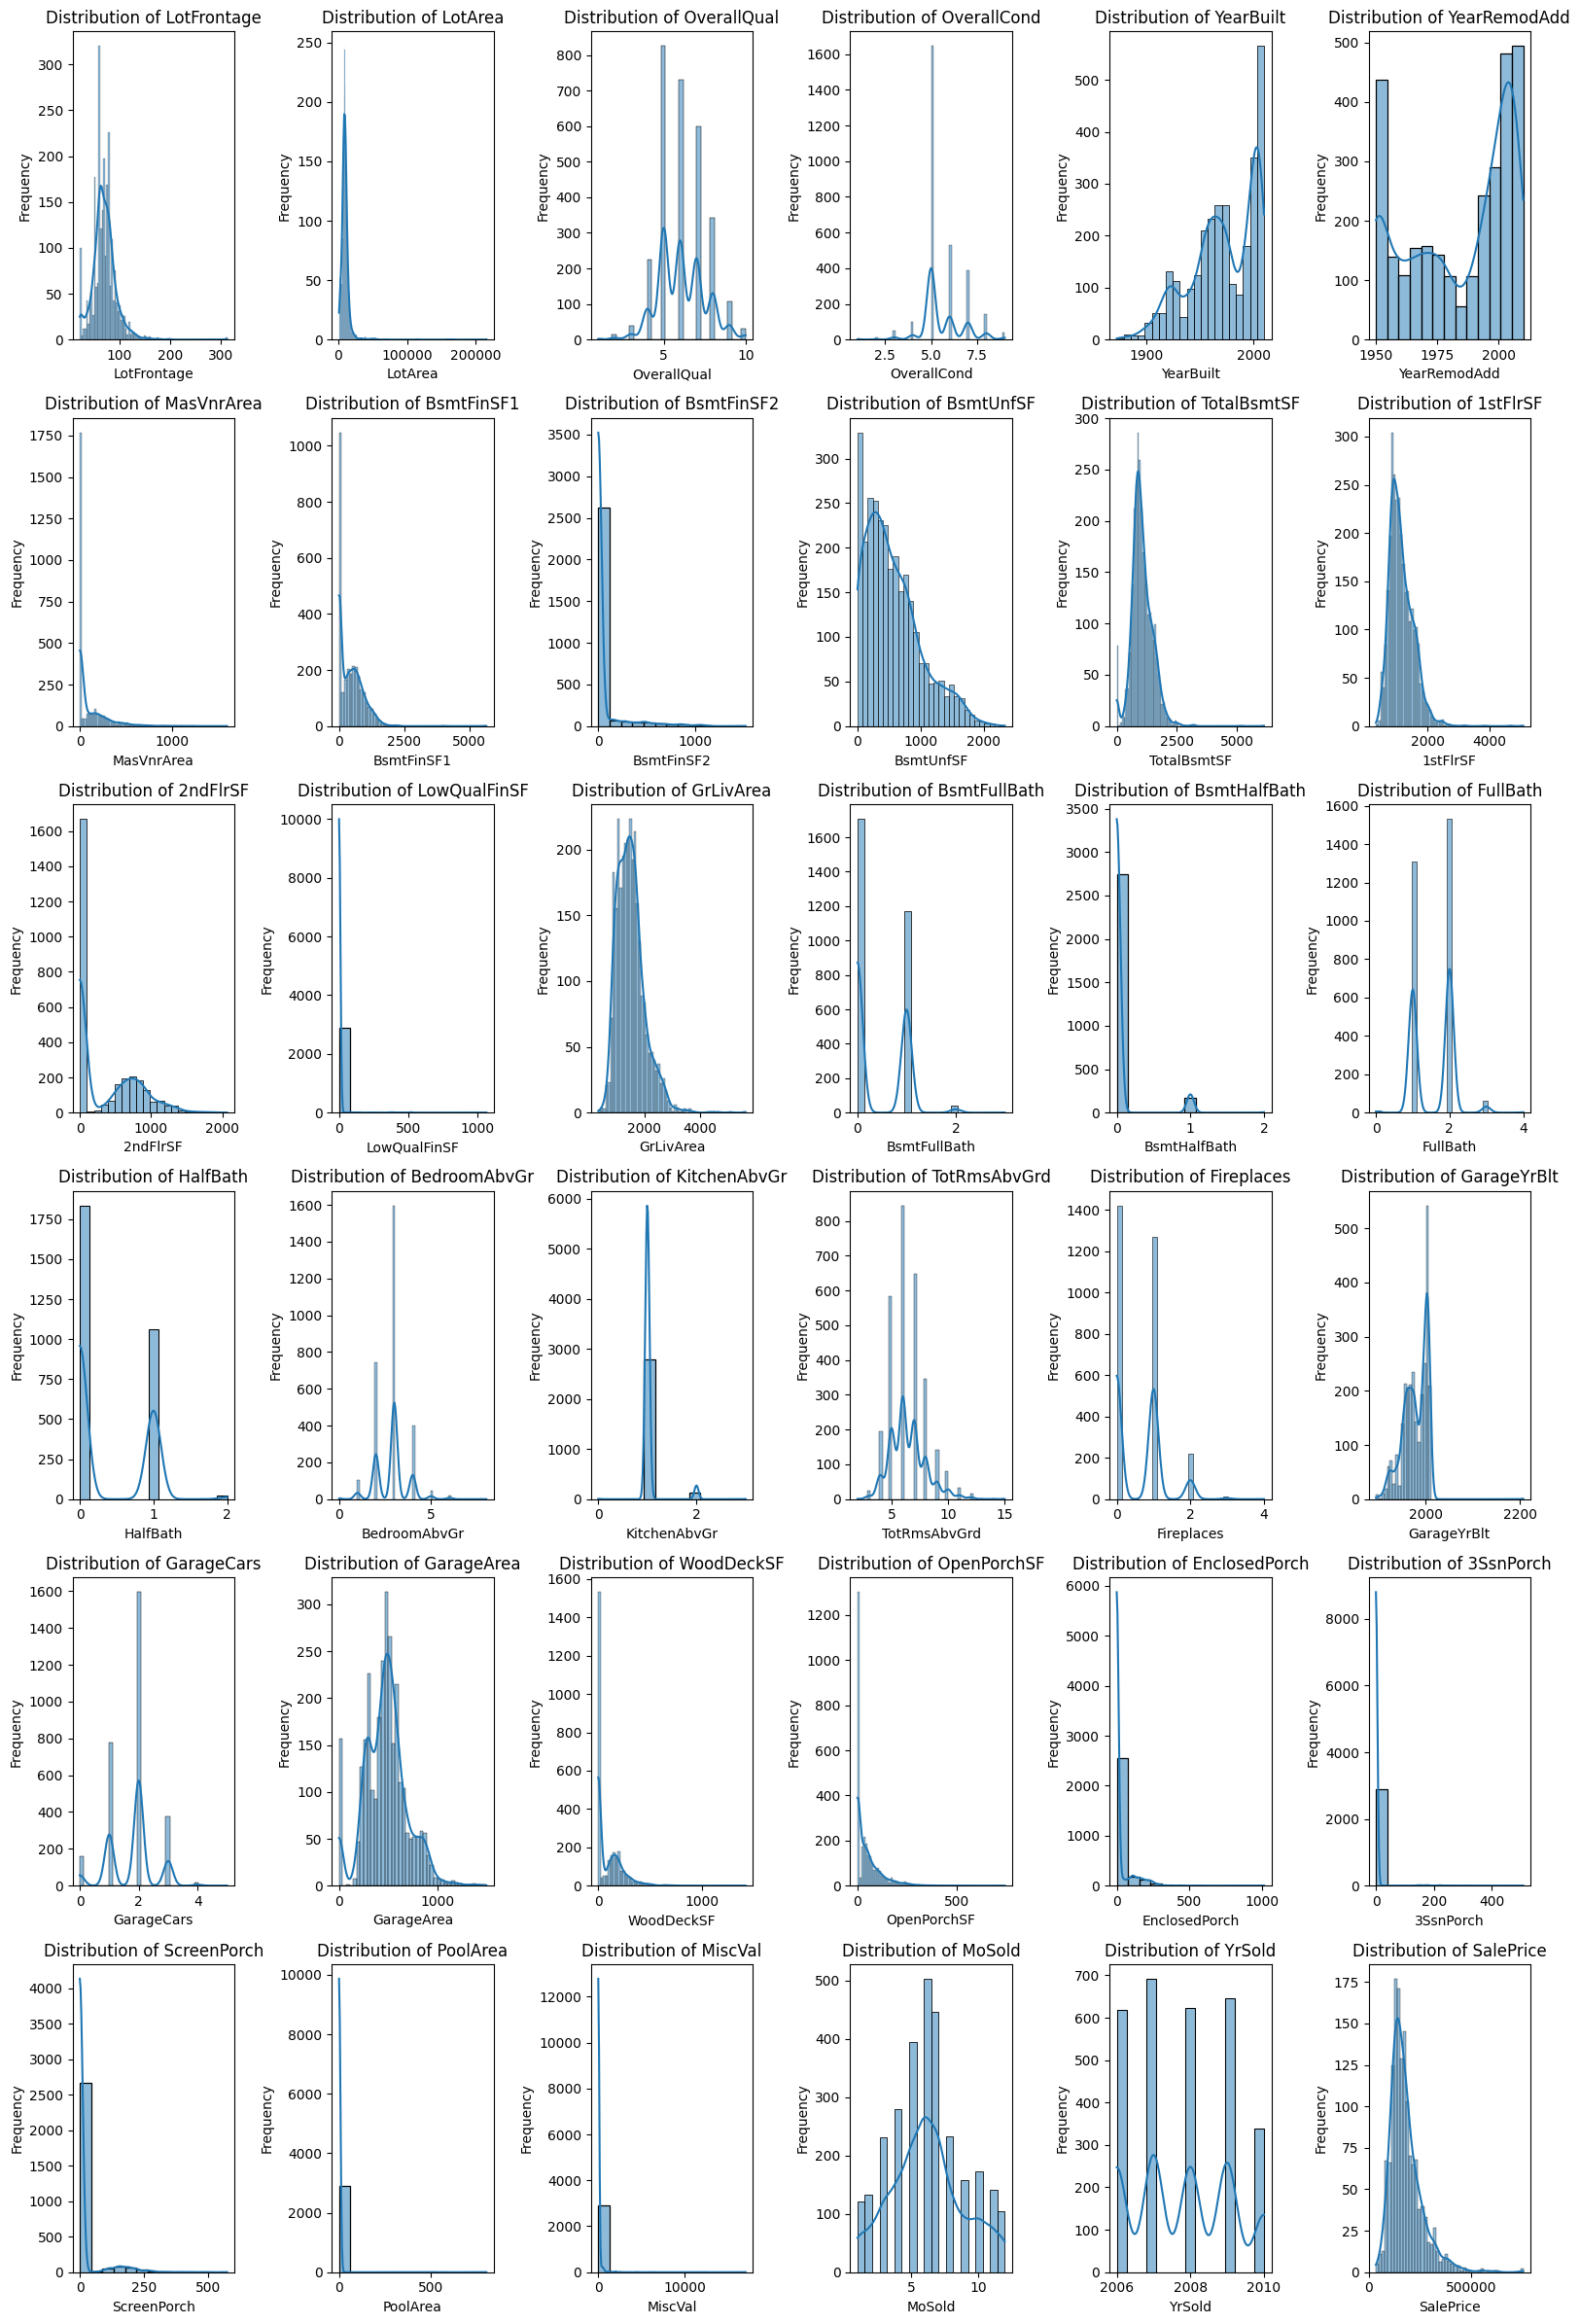

In [12]:
# Filter numeric columns
numerical_cols = df1.loc[:, df1.columns != 'Id'].select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns needed for subplots
num_vars = len(numerical_cols)
num_cols = int(np.ceil(np.sqrt(num_vars)))
num_rows = int(np.ceil(num_vars / num_cols))

# Set the figure size to make the plots readable
plt.figure(figsize=(16, 4 * num_rows))

# Iterate over the numeric columns and create a distribution plot for each one
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df1[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


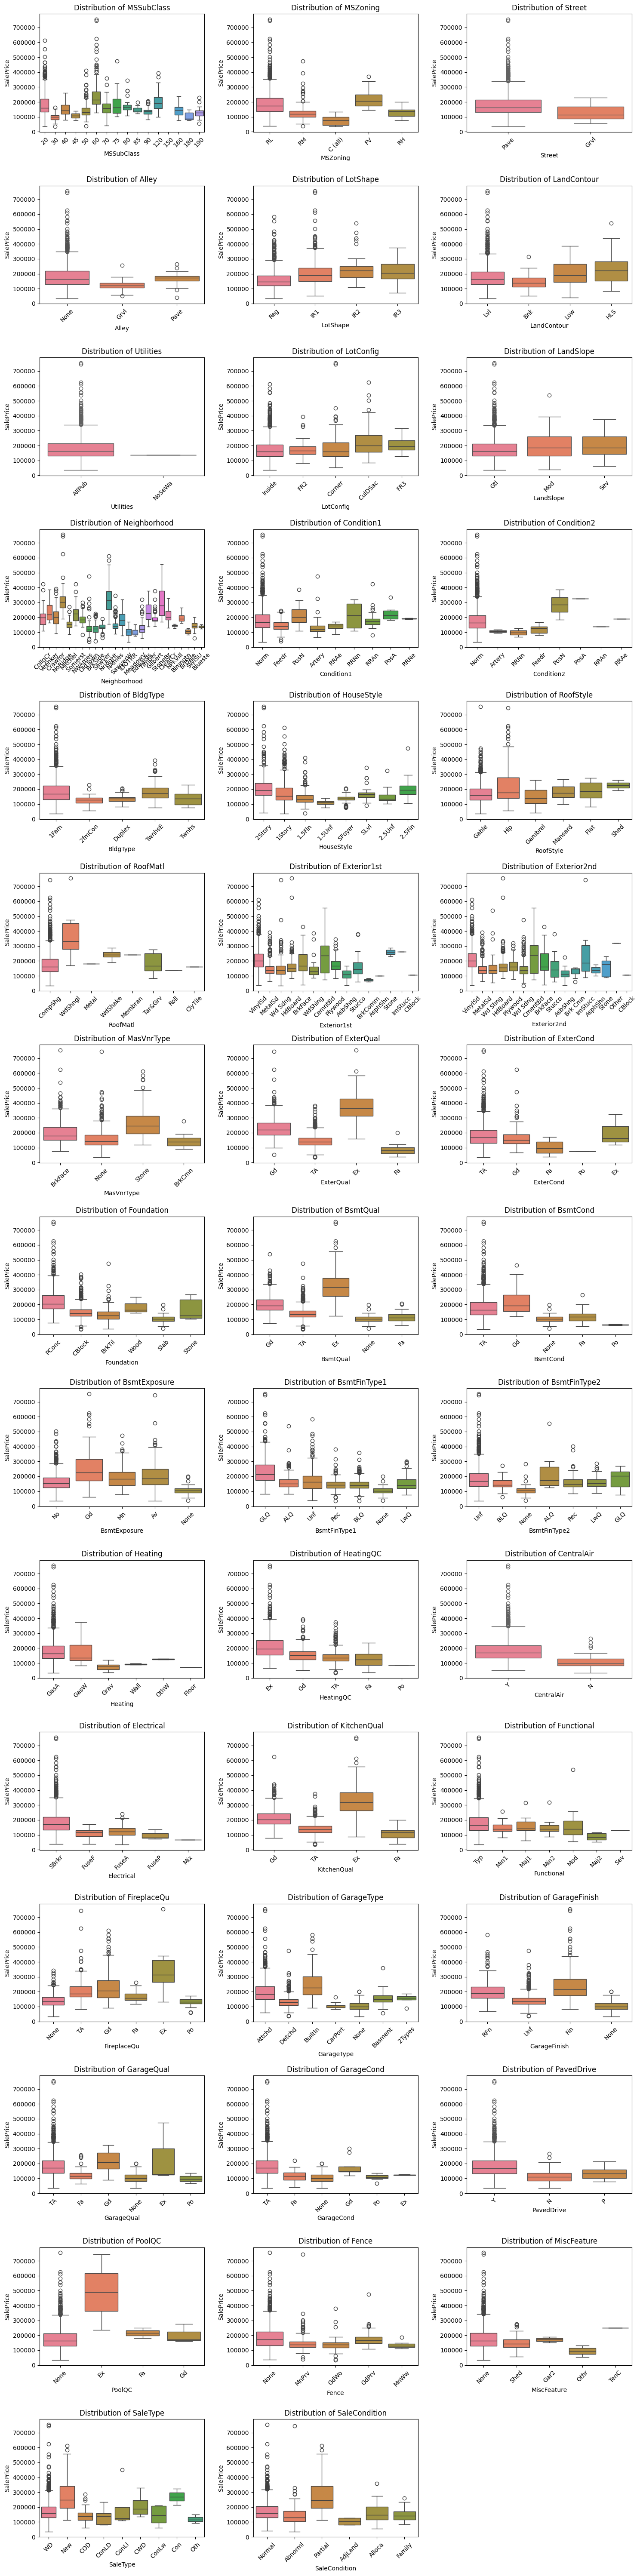

In [13]:
# Reset the index of DataFrame 'df1' and drop the old index
df1 = df1.reset_index(drop=True)

# Select categorical columns (excluding the 'Source' column)
categorical_cols = df1.drop('Source', axis=1).select_dtypes(include=['object']).columns

# Define the number of columns and rows
num_cols = 3
num_rows = -(-len(categorical_cols) // num_cols) 

# Create a figure and a grid of subplots with the specified size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axs = axs.ravel()

# Create a box plot using Seaborn, comparing the categorical column to 'SalePrice'
for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='SalePrice', data=df1, palette=sns.color_palette("husl", 20), ax=axs[i])
    
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)

# Hide any remaining empty subplots
for j in range(i + 1, num_cols * num_rows):
    axs[j].axis('off')

# Adjust and display the subplot grid
plt.tight_layout()
plt.show()


Analyzing the boxplots that relate to the categorical variables, we can see that variables 'Neighborhood, 'GarageFinish, and quality variable (KitchenQual,BsmtQual, ExterQual, etc)   have categories with significantly different medians, so they could have significant importance with our target variable. 
On the other hand, we have some variables like 'Alley, 'LandContour', 'PoolQC' and 'RoofMatl' that exhibit high variability within each category or have many outliers, which could make predictions difficult or introduce a lot of noise.


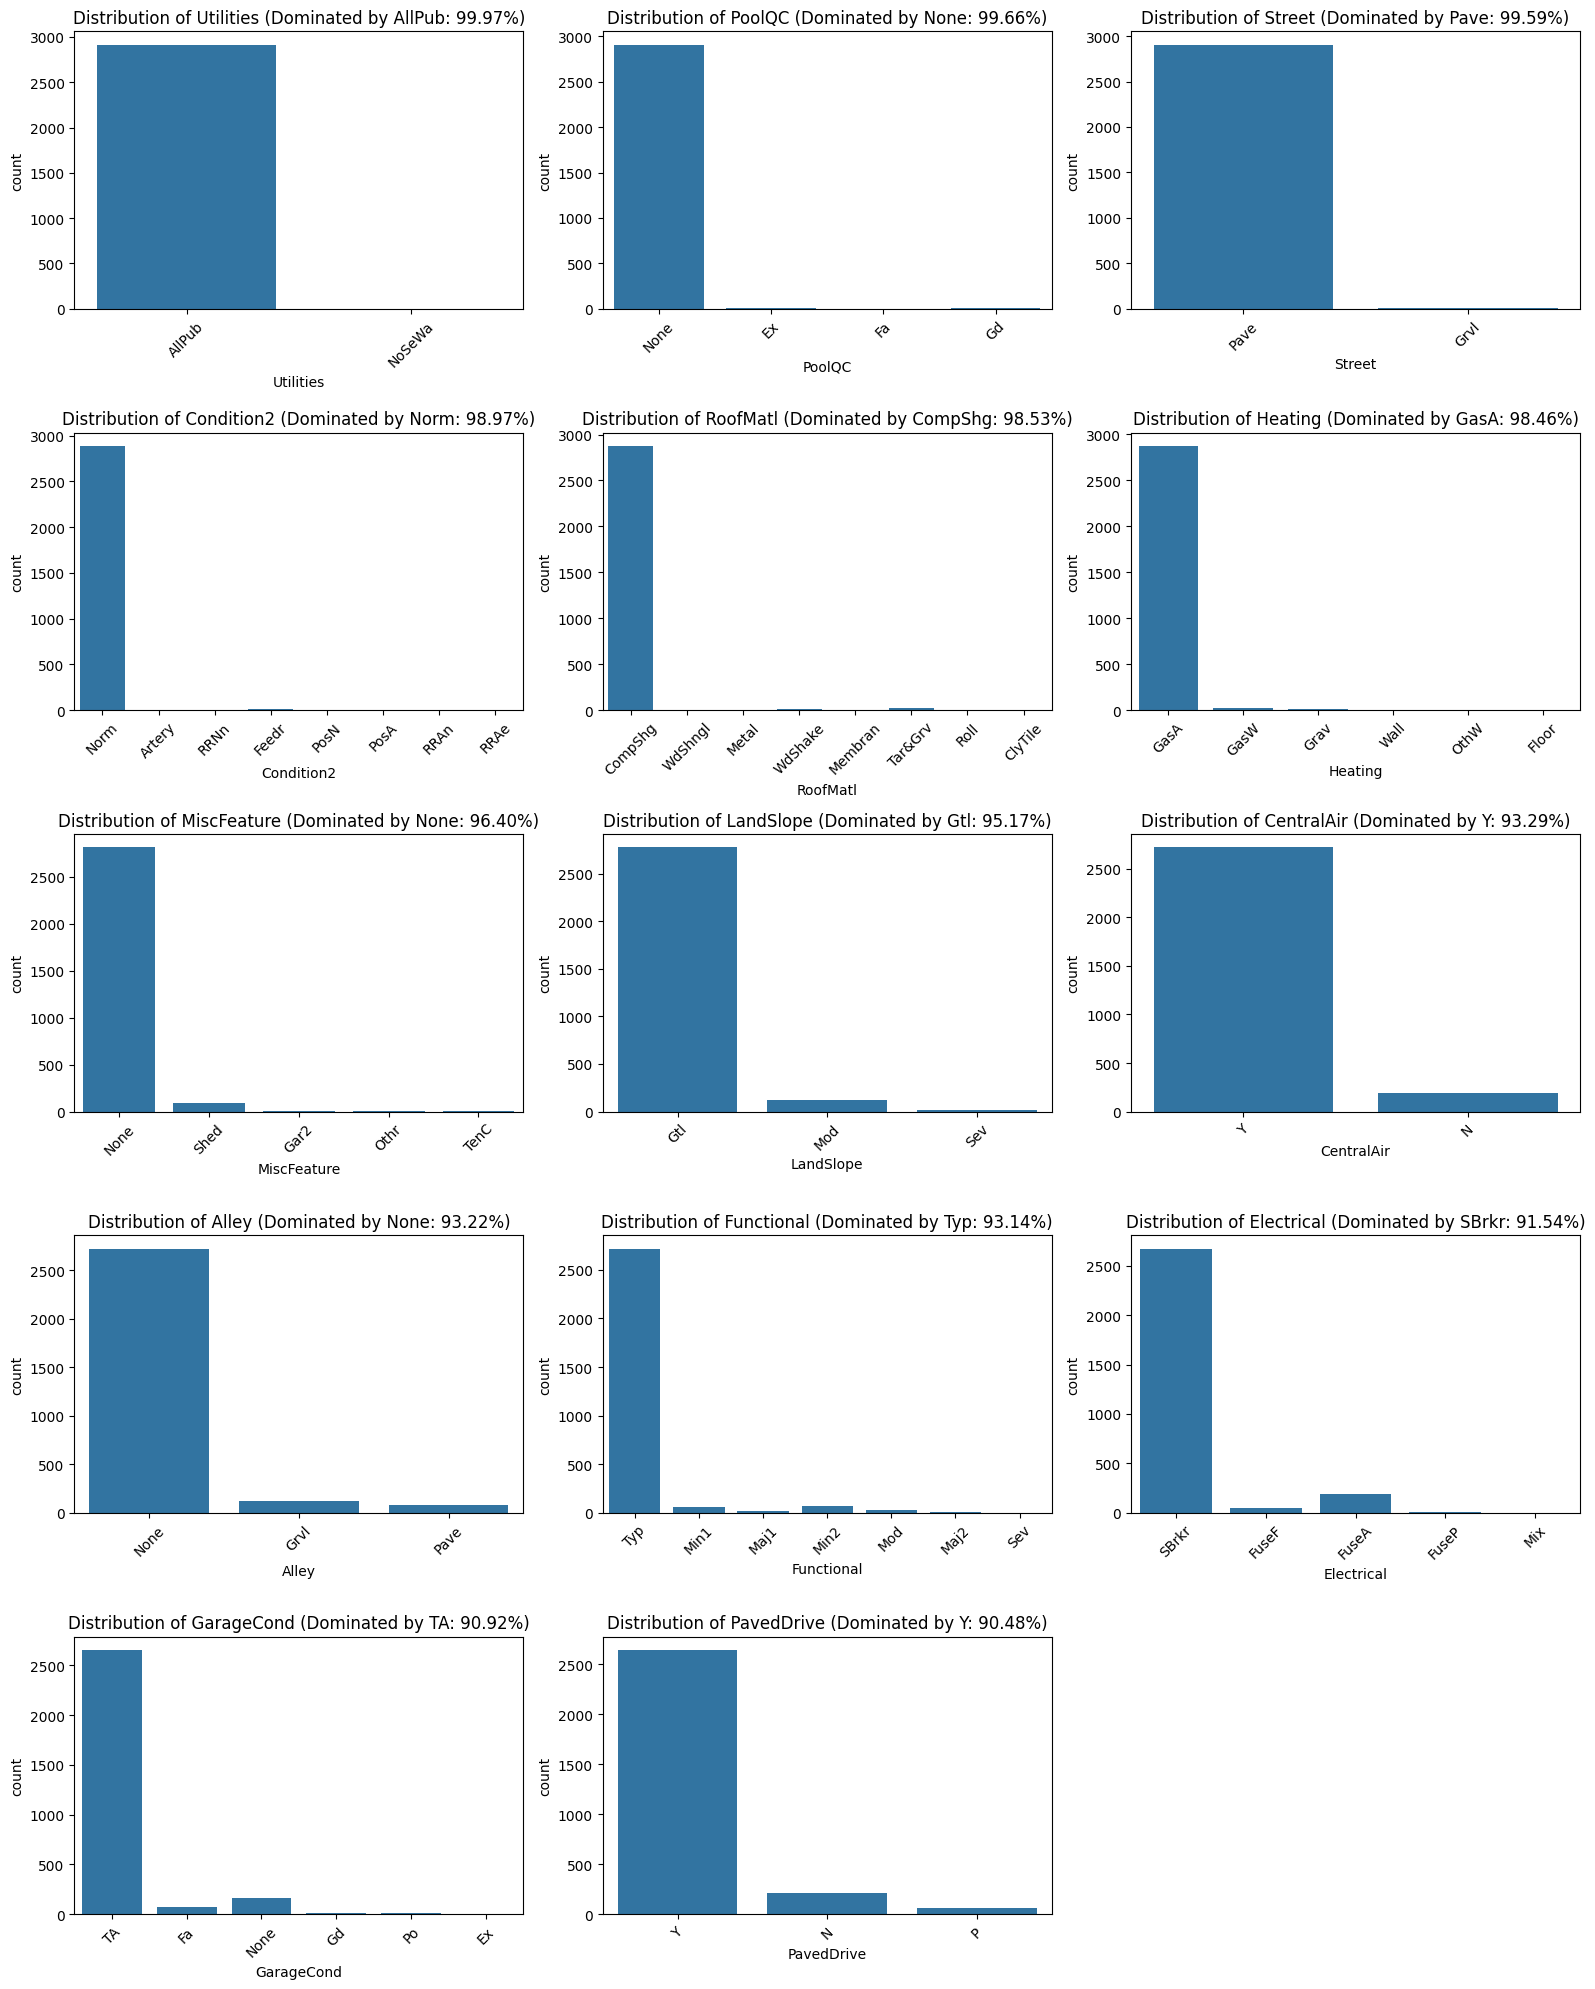

In [14]:
# Reset the DataFrame index and drop the old index
df1 = df1.reset_index(drop=True)

# Identify categorical columns in the DataFrame
cat_cols = df1.select_dtypes(include=['object']).columns.tolist()

# Find the dominant category and its percentage for each categorical column
dominant_category_percent = {}

for col in cat_cols:
    max_percent = df1[col].value_counts(normalize=True).max()
    dominant_category_percent[col] = max_percent

# Define a threshold for identifying imbalanced columns
threshold = 0.90

# Create a list of imbalanced columns based on the threshold
imbalanced_cols = [col for col, percent in dominant_category_percent.items() if percent > threshold]

# Sort imbalanced columns by dominance percentage
imbalanced_cols = sorted(imbalanced_cols, key=lambda x: -dominant_category_percent[x])

# Calculate the number of rows and columns for subplots
num_cols = len(imbalanced_cols)
num_rows = (num_cols + 2) // 3  # Round up to determine the number of rows

# Create subplots to visualize the distribution of imbalanced categorical data
fig, axs = plt.subplots(num_rows, 3, figsize=(16, num_rows * 4))
axs = axs.ravel()

for i, col in enumerate(imbalanced_cols):
    sns.countplot(data=df1, x=col, ax=axs[i])
    axs[i].set_title(f'Distribution of {col} (Dominated by {df1[col].mode()[0]}: {dominant_category_percent[col]*100:.2f}%)')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)

# Hide any remaining empty subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

# Adjust the layout and display the plot
plt.tight_layout()


In [15]:
# Create function thath analyze 0s and None values of a dataframe
def analyze_zeros_None(df):
    # Create a DataFrame to store the results
    result = pd.DataFrame(index=df.loc[:, df.columns != 'Id'].columns, columns=['# of Zeros', 'Percentage of Zeros', '# of None', 'Percentage of None', '# of NaN', 'Percentage of NaN'])

    # Calculate the number and percentage of 0s, 'None', and NaNs for each column
    for col in df.columns:
        result.loc[col, '# of Zeros'] = (df[col] == 0).sum()
        result.loc[col, 'Percentage of Zeros'] = (df[col] == 0).mean() * 100
        result.loc[col, '# of None'] = (df[col] == 'None').sum()
        result.loc[col, 'Percentage of None'] = (df[col] == 'None').mean() * 100
        result.loc[col, '# of NaN'] = df[col].isnull().sum()
        result.loc[col, 'Percentage of NaN'] = df[col].isnull().mean() * 100
        
    result = result.sort_values(by=['Percentage of Zeros', 'Percentage of None'], ascending=False)
    return result

analyze_zeros_None(df1)

# of Zeros Percentage of Zeros # of None Percentage of None  \
PoolArea            2906           99.554642         0                0.0   
3SsnPorch           2882           98.732443         0                0.0   
LowQualFinSF        2879           98.629668         0                0.0   
MiscVal             2816           96.471394         0                0.0   
BsmtHalfBath        2742            93.93628         0                0.0   
ScreenPorch         2663           91.229873         0                0.0   
BsmtFinSF2          2571           88.078109         0                0.0   
EnclosedPorch       2460           84.275437         0                0.0   
HalfBath            1834           62.829736         0                0.0   
MasVnrArea          1738           59.540939         0                0.0   
BsmtFullBath        1705           58.410415         0                0.0   
2ndFlrSF            1668           57.142857         0                0.0   
WoodDeckSF          1523           52.175403         0                0.0   
Fireplaces          1420           48.646797         0                0.0   
OpenPorchSF         1298           44.467283         0                0.0   
BsmtFinSF1           929           31.825968         0                0.0   
BsmtUnfSF            241            8.256252         0                0.0   
GarageCars           157            5.378554         0                0.0   
GarageArea           157            5.378554         0                0.0   
TotalBsmtSF           78            2.672148         0                0.0   
FullBath              12              0.4111         0                0.0   
BedroomAbvGr           8            0.274066         0                0.0   
KitchenAbvGr           3            0.102775         0                0.0   
PoolQC                 0                 0.0      2909          99.657417   
MiscFeature            0                 0.0      2814          96.402878   
Alley                  0                 0.0      2721          93.216855   
Fence                  0                 0.0      2348          80.438506   
MasVnrType             0                 0.0      1766          60.500171   
FireplaceQu            0                 0.0      1420          48.646797   
GarageFinish           0                 0.0       159           5.447071   
GarageQual             0                 0.0       159           5.447071   
GarageCond             0                 0.0       159           5.447071   
GarageType             0                 0.0       157           5.378554   
BsmtCond               0                 0.0        82           2.809181   
BsmtExposure           0                 0.0        82           2.809181   
BsmtQual               0                 0.0        81           2.774923   
BsmtFinType2           0                 0.0        80           2.740665   
BsmtFinType1           0                 0.0        79           2.706406   
MSSubClass             0                 0.0         0                0.0   
MSZoning               0                 0.0         0                0.0   
LotFrontage            0                 0.0         0                0.0   
LotArea                0                 0.0         0                0.0   
Street                 0                 0.0         0                0.0   
LotShape               0                 0.0         0                0.0   
LandContour            0                 0.0         0                0.0   
Utilities              0                 0.0         0                0.0   
LotConfig              0                 0.0         0                0.0   
LandSlope              0                 0.0         0                0.0   
Neighborhood           0                 0.0         0                0.0   
Condition1             0                 0.0         0                0.0   
Condition2             0                 0.0         0                0.0   
BldgType  

In [16]:
fig = px.scatter(raw_train_df, x='GrLivArea', y='SalePrice', 
                 hover_data=['GrLivArea', 'SalePrice'], # Data shown on hover
                 title='Interactive Scatter Plot of GrLivArea vs SalePrice',
                 labels={'GrLivArea': 'living area', 'SalePrice': 'Sale Price'})

# Show plot
fig.show()

In [17]:
# Identifies house with more than 4000 square feet and cost less than 200k
raw_train_df[(raw_train_df['GrLivArea'] > 4000) & (raw_train_df['SalePrice'] < 200000)]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524         60       RL        130.0    40094   Pave  None      IR1   
1298  1299         60       RL        313.0    63887   Pave  None      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
523          Bnk    AllPub    Inside       Gtl      Edwards       PosN   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
523        PosN     1Fam     2Story           10            5       2007   
1298       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
523           2008       Hip  CompShg     CemntBd     CmentBd      Stone   
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
523        762.0        Ex        TA      PConc       Ex       TA   
1298       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
523            Gd          GLQ      2260.0          Unf         0.0   
1298           Gd          GLQ      5644.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
523       878.0       3138.0    GasA        Ex          Y      SBrkr   
1298      466.0       6110.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
523       3138      1538             0       4676           1.0           0.0   
1298      4692       950             0       5642           2.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
523          3         1             3             1          Ex   
1298         2         1             3             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
523             11        Typ           1          Gd    BuiltIn       2007.0   
1298            12        Typ           3          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
523           Fin         3.0       884.0         TA         TA          Y   
1298          Fin         2.0      1418.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
523          208          406              0          0            0   
1298         214          292              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
523          0   None  None        None        0      10    2007      New   
1298       480     Gd  None        None        0       1    2008      New   

     SaleCondition  SalePrice Source   YrMoSold  
523        Partial   184750.0  Train 2007-10-01  
1298       Partial   160000.0  Train 2008-01-01

The two records, which we might regard as anomalies for having living areas (above ground) larger than 4000 square feet and priced under 200K, won't be treated as such. Although both records have an OverallQual value of 5, suggesting a potential anomaly, the variables GarageCars, GarageArea, and TotalBath align with the house prices. Furthermore, one of them was sold in 2008, a year when house prices declined.

In [18]:
# Calculate total bathrooms
raw_train_df['TotalBaths'] = (raw_train_df['FullBath'] + 0.5*raw_train_df['HalfBath'] + 
                              raw_train_df['BsmtFullBath'] + 0.5*raw_train_df['BsmtHalfBath'])

# Create histogram for TotalRooms vs SalePrice
fig_rooms = px.histogram(raw_train_df, x='TotRmsAbvGrd', y='SalePrice', histfunc='avg',
                         labels={'TotalRooms': 'Total Rooms', 'SalePrice': 'Average Sale Price'},
                         title='Average Sale Price vs Total Rooms')
fig_rooms.show()

# Create histogram for TotalBaths vs SalePrice
fig_baths = px.histogram(raw_train_df, x='TotalBaths', y='SalePrice', histfunc='avg',
                         labels={'TotalBaths': 'Total Bathrooms', 'SalePrice': 'Average Sale Price'},
                         title='Average Sale Price vs Total Bathrooms')
fig_baths.show()

In [19]:
# Identifies the records that have more than 4.5 bathrooms
raw_train_df[(raw_train_df['TotalBaths'] >= 5)]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
738  739         90       RL         60.0    10800   Pave  None      Reg   
921  922         90       RL         67.0     8777   Pave  None      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
738         Lvl    AllPub    Inside       Gtl      Edwards       Norm   
921         Lvl    AllPub    Inside       Gtl      Edwards      Feedr   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
738       Norm   Duplex     1Story            5            5       1987   
921       Norm   Duplex     1.5Fin            5            7       1900   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
738          1988     Gable  CompShg     Plywood     Plywood       None   
921          2003     Gable  CompShg     MetalSd     MetalSd       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
738         0.0        TA        TA     CBlock       Gd       Gd           Gd   
921         0.0        TA        TA     CBlock       TA       TA           No   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
738          GLQ      1200.0          Unf         0.0        0.0       1200.0   
921          ALQ      1084.0          Unf         0.0      188.0       1272.0   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
738    GasA        TA          Y      SBrkr      1200         0             0   
921    GasA        Gd          Y      SBrkr      1272       928             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
738       1200           3.0           0.0         3         0             3   
921       2200           2.0           0.0         2         2             4   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
738             1          TA             5        Typ           0   
921             2          TA             9        Typ           0   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
738        None       None          NaN         None         0.0         0.0   
921        None       None          NaN         None         0.0         0.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
738       None       None          Y         120            0              0   
921       None       None          N           0           70              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  \
738          0            0         0   None   None        None        0   
921          0            0         0   None  GdPrv        None        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice Source   YrMoSold  \
738       3    2009       WD        Alloca   179000.0  Train 2009-03-01   
921       9    2008       WD        Normal   145900.0  Train 2008-09-01   

     TotalBaths  
738         6.0  
921         5.0

Houses with more than four bathrooms display unusual behavior concerning the general relationship noted between the total number of bathrooms and the house price (where more bathrooms typically suggest a higher price). Upon detailed examination of these records, we do not categorize them as anomalies since the variables OverallQual, GarageCars, GrLivArea, and YrSold align coherently with the prices of these houses.

In [20]:
fig_OverallQual = px.histogram(raw_train_df, x='OverallQual', y='SalePrice', histfunc='avg',
                         labels={'OverallCond': 'Overall Quality', 'SalePrice': 'Average Sale Price'},
                         title='Average Sale Price vs Overall Quality')
fig_OverallQual.show()

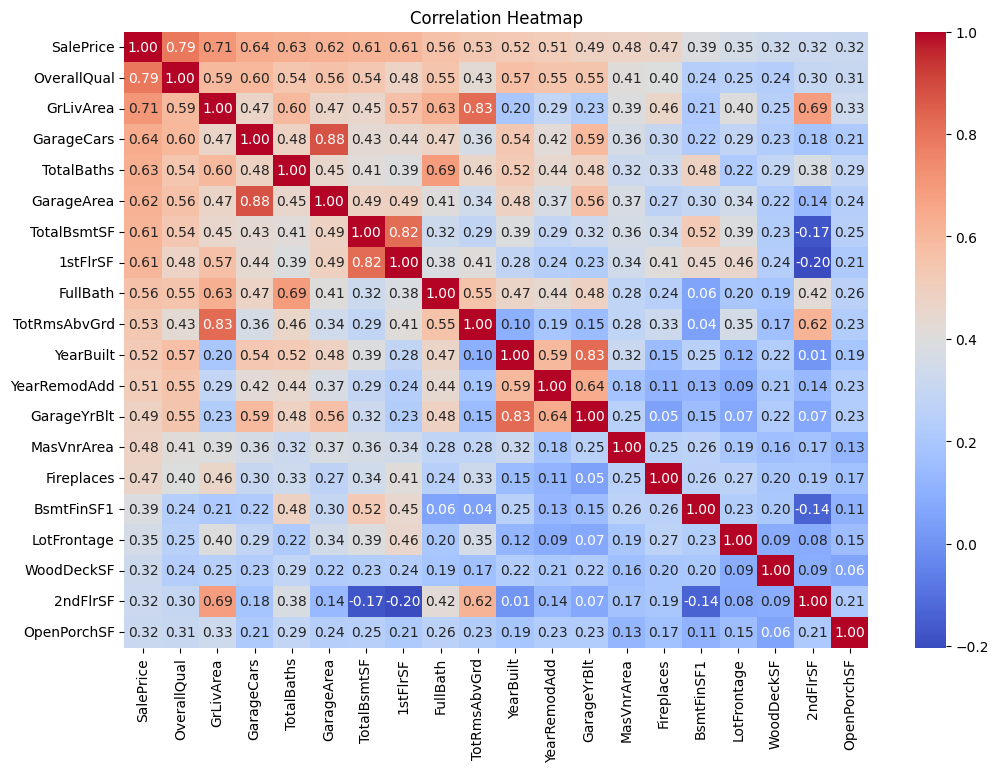

In [21]:
# Compute correlation matrix
corr_matrix = raw_train_df.loc[:, raw_train_df.columns != 'Id'].select_dtypes(include=['float64', 'int64']).corr()

# Select the correlations between all variables and target variable 'SalePrice'
target_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

# Selects the 20 variables with highest correlations 
top_corr_vars = target_corr.abs().head(20).index 


# Compute correlation matrix with selected variables
top_corr_matrix = raw_train_df[top_corr_vars].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Conclusions from the Exploratory Data Analysis (EDA) of Raw Data:
- There is a noticeable dip in house sale prices in 2008, likely due to the financial crisis, with the highest sale prices recorded in 2006 and 2007.
- Homes built from 1985 onwards tend to have sale prices above the average.
- We identified variables, like Neighborhood and quality columns, that are significantly correlated with the sale price.
- We haven't detected any anomalous data.
- We have identified a new variable that shows a high correlation with the target variable (SalePrice). This variable is TotalBaths.
- We observe several features that have a skewed distribution. We are considering applying a transformation to these so that their distribution is more symmetric.
- After examining the occurrence of 0 and None values within our variables, we've decided to remove those that display over 90% of such values. The variables pinpointed for removal are: 'PoolArea', '3SsnPorch', 'LowQualFinSf', 'MiscVal', 'PoolQC', 'MiscFeature'
- Following a thorough analysis, we have decided to eliminate those categorical columns that are unbalanced, with one category prevailing in more than 90% of the instances.These variables are: 'Utilities', 'PoolQC', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature', 'LandSlope', 'CentralAir', 'Alley', 'Functional', 'Electrical', 'GarageCond', 'PavedDrive'

## Handle null values

During the null values handling process, we'll work with the complete data set (train.csv and test.csv). The 'SalePrice' variable has 1459 null values, corresponding to all the records in the test.csv file. 

In [22]:
# Calculate the percentage of missing values for each column
missing_data = df1.isnull().sum()
missing_percentage = (df1.isnull().sum() / len(df1)) * 100

# Create a DataFrame to show missing data and missing percentage
missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})

# Sort the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage (%)', ascending=False)

# Show columns where missing values exist
missing_info[missing_info['Missing Values'] > 0]

Missing Values  Percentage (%)
SalePrice               1459       49.982871
LotFrontage              486       16.649538
GarageYrBlt              159        5.447071
MasVnrArea                23        0.787941
MSZoning                   4        0.137033
BsmtHalfBath               2        0.068517
BsmtFullBath               2        0.068517
Functional                 2        0.068517
Utilities                  2        0.068517
BsmtUnfSF                  1        0.034258
BsmtFinSF2                 1        0.034258
BsmtFinSF1                 1        0.034258
TotalBsmtSF                1        0.034258
KitchenQual                1        0.034258
GarageCars                 1        0.034258
Electrical                 1        0.034258
GarageArea                 1        0.034258
Exterior2nd                1        0.034258
Exterior1st                1        0.034258
SaleType                   1        0.034258

In [23]:
# Create a copy 'df2' of original dataframe to clean null values
df2 = df1.copy()

In [24]:
#Set null values of the 'LotFrontage' column by regresion
# Seleccionar variables predictoras y eliminar filas con valores nulos en esas variables
predictors = ['LotArea', 'GrLivArea', 'GarageArea']  # Reemplaza con tus variables predictoras
data_with_predictions = df2.dropna(subset=predictors)

# Crear conjunto de entrenamiento y prueba
train = data_with_predictions.dropna(subset=['LotFrontage'])
test = data_with_predictions[data_with_predictions['LotFrontage'].isnull()]

# Separar variables predictoras y objetivo
X_train = train[predictors]
y_train = train['LotFrontage']
X_test = test[predictors]

# Crear y entrenar el modelo de regresión
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones
predicted = model.predict(X_test)

# Reemplazar valores nulos con predicciones
df2.loc[df2['LotFrontage'].isnull(), 'LotFrontage'] = predicted

In [25]:
#set Masonry veneer area to 0 when is null
df2.loc[df2['MasVnrArea'].isna(), 'MasVnrArea' ] = 0.0

In [26]:
#Avoid that the remodel date being older than construction date
df2.loc[df2['YearBuilt'] > df2['YearRemodAdd'],'YearRemodAdd'] =  df2[df2['YearBuilt'] 
                                                                   > df2['YearRemodAdd']]['YearBuilt']

In [27]:
#When there is no garage construction date is -1. So, we only work with positive values
df2.loc[df2['GarageType'] == 'None', 'GarageYrBlt'] = 0

In [28]:
#For the rest of columns with null values we use mode value of each column
for column in ['MSZoning', 'Utilities', 'Exterior1st', 'Electrical', 'Functional', 'KitchenQual','SaleType', 'GarageQual']:
    df2[column] = df2[column].fillna(df2[column].mode()[0])

#Use the same material exterior covering on house thant the first one
df2['Exterior2nd'] = df2['Exterior2nd'].fillna(df2['Exterior1st'])

In [29]:
#Modify register where there is no basement 
bsmt1_numeric_column = ['BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF']
for col in bsmt1_numeric_column:
    df2.loc[df2['BsmtFinType1'] == 'None', col] = 0.0
    
df2.loc[df2['BsmtFinType2'] == 'None', 'BsmtFinSF2'] = 0.0

In [30]:
#check no null values
missing_values_final = pd.DataFrame({
    'Missing Values': df2.isna().sum()})
missing_values_final[missing_values_final['Missing Values'] >0]

Missing Values
GarageYrBlt               2
GarageCars                1
GarageArea                1
SalePrice              1459

In [31]:
# Observe record with null values
df2[(df2['GarageYrBlt'].isna())]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2126  2127         60       RM         57.0     8094   Pave  Grvl      Reg   
2576  2577         70       RM         50.0     9060   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2126         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
2576         Lvl    AllPub    Inside       Gtl       IDOTRR       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
2126       Norm   2fmCon     2.5Unf            6            8       1910   
2576       Norm     1Fam     2Story            5            6       1923   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2126          1983     Gable  CompShg     Wd Sdng     Wd Sdng       None   
2576          1999     Gable  CompShg     Wd Sdng     Plywood       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
2126         0.0        TA        TA      PConc       TA       TA   
2576         0.0        TA        TA     BrkTil       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
2126           Mn          Rec       196.0          Unf         0.0   
2576           No          ALQ       548.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
2126     1046.0       1242.0    GasA        Gd          Y      SBrkr   
2576      311.0        859.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
2126      1242       742             0       1984           0.0           0.0   
2576       942       886             0       1828           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
2126         2         0             5             1          TA   
2576         2         0             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
2126             8        Typ           0        None     Detchd          NaN   
2576             6        Typ           0        None     Detchd          NaN   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
2126         None         1.0       360.0       None       None          Y   
2576         None         NaN         NaN       None       None          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
2126          64            0            180          0            0   
2576         174            0            212          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
2126         0   None  MnPrv        Shed     1000       9    2008       WD   
2576         0   None  MnPrv        None        0       3    2007       WD   

     SaleCondition  SalePrice Source  
2126        Normal        NaN   Test  
2576        Alloca        NaN   Test

In [32]:
df2.loc[(df2['GarageYrBlt'].isna()) & (df2['GarageCars'].isna()), 'GarageCars'] = 0
df2.loc[(df2['GarageYrBlt'].isna()) & (df2['GarageCars'].isna()), 'GarageYrBlt'] = df2[(df2['GarageYrBlt'].isna()) & 
                                                                                       (df2['GarageCars'].isna())]['YearBuilt']
df2.loc[(df2['GarageArea'].isna()), 'GarageArea'] = 0

df2.loc[(df2['GarageYrBlt'].isna()), 'GarageYrBlt']  = df2[(df2['GarageYrBlt'].isna())]['YearBuilt']

In [33]:
# Check null values
missing_values_final = pd.DataFrame({
    'Missing Values': df2.isna().sum()})
missing_values_final[missing_values_final['Missing Values'] >0]

Missing Values
SalePrice            1459

## Data cleaning

During the data cleaning process, we will work with the complete dataset (combining train.csv and test.csv). In this section, we plan to:
- Remove columns mentioned in the EDA conclusions:
    1. Variables with over 90% of data having a value of 0 or 'None': 'PoolArea', '3SsnPorch', 'LowQualFinSf', 'MiscVal', 'PoolQC', and 'MiscFeature'.
    2. Unbalanced categorical variables where the dominant category represents more than 90%: 'Utilities', 'PoolQC', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature', 'LandSlope', 'CentralAir', 'Alley', 'Functional', 'Electrical', 'GarageCond', and 'PavedDrive'.
- Implement rules to ensure data consistency. These conditions apply only to training data since we cannot remove records from the test set. The conditions include:
    1. If there's no masonry work, the masonry area cannot be greater than 0.
    2.Basement-related variables should consistently indicate the presence or absence of a basement.
    3. There are discrepancies regarding the variable identifying the type of dwelling (MSSubClass) and the year of construction.
    4. 'HouseStyle' and 'MSSubClass' variables do not match.
    5. A 1-story style house cannot have square footage recorded under the '2ndFloorSF' 
- Apply logarithmic and square root transformation to asymmetric columns seen in the EDA Raw Data: 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','WoodDeckSF', 'OpenPorchSF'

We will review the number of records that might be lost upon applying each of these conditions.



In [34]:
# Select columns to remove
col_to_delete = [ 'Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating','PoolArea', '3SsnPorch', 
                 'LowQualFinSF', 'MiscVal', 'PoolQC', 'MiscFeature' ,'LandSlope', 'CentralAir', 'Alley', 
                 'Functional', 'Electrical', 'GarageCond', 'PavedDrive']
# Delete column
df2_cleaned = df2.drop(col_to_delete, axis=1)

# We display the names of the columns in our dataset.
df2_cleaned.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Fence',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'Source'],
      dtype='object')

In [35]:
# We select the training data.
train_data = df2_cleaned[df2_cleaned['Source'] == 'Train'].copy()

# We create a dictionary with the conditions mentioned earlier.
conditions = {
    'condition1': (
        (train_data['MasVnrType'] == 'None') & (train_data['MasVnrArea'] == 0.0) |
        (train_data['MasVnrType'] != 'None') & (train_data['MasVnrArea'] > 0.0)
    ),
    'condition2': (
        (train_data['BsmtFinType1'] == 'None') & (train_data['BsmtQual'] == 'None') & 
        (train_data['BsmtCond'] == 'None') & (train_data['BsmtExposure'] == 'None')
    ) | (
        (train_data['BsmtFinType1'] != 'None') & (train_data['BsmtQual'] != 'None') & 
        (train_data['BsmtCond'] != 'None') & (train_data['BsmtExposure'] != 'None')
    ),
    'condition3': (
    ~((train_data['MSSubClass'] == 20) & (train_data['YearBuilt'] < 1946)) &
    ~((train_data['MSSubClass'] == 30) & (train_data['YearBuilt'] >= 1946)) &
    ~((train_data['MSSubClass'] == 60) & (train_data['YearBuilt'] < 1946)) &
    ~((train_data['MSSubClass'] == 70) & (train_data['YearBuilt'] >= 1946)) &
    ~((train_data['MSSubClass'] == 120) & (train_data['YearBuilt'] < 1946)) &
    ~((train_data['MSSubClass'] == 160) & (train_data['YearBuilt'] < 1946))
    ),
    'condition4': (
    # 1-STORY 1946 & NEWER ALL STYLES
    ~((train_data['MSSubClass'] == 20) & ~(train_data['HouseStyle'] == '1Story')) &
    # 1-1/2 STORY - UNFINISHED ALL AGES
    ~((train_data['MSSubClass'] == 45) & ~train_data['HouseStyle'].str.startswith('1.5')) &
    # 1-1/2 STORY FINISHED ALL AGES
    ~((train_data['MSSubClass'] == 50) & ~train_data['HouseStyle'].str.startswith('1.5')) &
    # 2-STORY 1946 & NEWER
    ~((train_data['MSSubClass'] == 60) & ~(train_data['HouseStyle'] == '2Story')) &
    # 2-1/2 STORY ALL AGES
    ~((train_data['MSSubClass'] == 75) & ~train_data['HouseStyle'].str.startswith('2.5'))
    ),
    'condition5': (
    # 1Story should have 2ndFlrSF as 0
    ~((train_data['HouseStyle'] == '1Story') & (train_data['2ndFlrSF'] != 0)) &
    # 1.5Fin or 1.5Unf should have 2ndFlrSF greater than 0
    ~((train_data['HouseStyle'].str.startswith('1.5')) & (train_data['2ndFlrSF'] == 0)) &
    # 2Story should have 2ndFlrSF greater than 0
    ~((train_data['HouseStyle'] == '2Story') & (train_data['2ndFlrSF'] == 0)) &
    # 2.5Fin or 2.5Unf should have 2ndFlrSF greater than 0
    ~((train_data['HouseStyle'].str.startswith('2.5')) & (train_data['2ndFlrSF'] == 0))
    )
}

# We apply each condition and display the number of lost records.
combined_condition = pd.Series([True]*len(train_data), index=train_data.index)
for condition_name, condition in conditions.items():
    filtered_df = train_data[condition]
    lost_records = len(train_data) - len(filtered_df)
    combined_condition &= condition
    lost_records_porcentage = (lost_records/ len(train_data))*100
    print(f"Lost record applying {condition_name}: {lost_records}")
    print(f"Percentage of lost record applying {condition_name}: {lost_records_porcentage}")
    
# We apply all conditions at once and count the number of records lostHEMOS A
filtered_train_data = train_data[combined_condition]
lost_records = len(train_data) - len(filtered_train_data)
lost_records_porcentage = (lost_records/ len(train_data))*100
print(f"\nLost record applying all conditions: {lost_records}")
print(f" Percentage of lost record applying all conditions: {lost_records_porcentage}")

Lost record applying condition1: 7
Percentage of lost record applying condition1: 0.4794520547945206
Lost record applying condition2: 1
Percentage of lost record applying condition2: 0.0684931506849315
Lost record applying condition3: 2
Percentage of lost record applying condition3: 0.136986301369863
Lost record applying condition4: 7
Percentage of lost record applying condition4: 0.4794520547945206
Lost record applying condition5: 24
Percentage of lost record applying condition5: 1.643835616438356

Lost record applying all conditions: 41
 Percentage of lost record applying all conditions: 2.808219178082192


In [36]:
# Selecting test data
test_data = df2_cleaned[df2_cleaned['Source'] == 'Test']
# Concatenating filtered train and test data
df2_cleaned = pd.concat([filtered_train_data, test_data], axis=0)
# Resetting index
df2_cleaned.reset_index(drop=True, inplace=True)


In [37]:
# Columns to apply logarithmic transformation
col_log_transform = ['LotFrontage', 'LotArea']
# Columns to apply square root transformation
col_sqrt_transform = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','WoodDeckSF', 'OpenPorchSF']

# Applying logarithmic transformation to specified columns
for col in col_log_transform:
    df2_cleaned[col] = np.log1p(df2_cleaned[col])
    
# Applying square root transformation to specified columns
for col in col_sqrt_transform:
    df2_cleaned[col] = np.sqrt(df2_cleaned[col])


### EDA Post Data Cleaning

In this section, we are going to revisit the distributions of the numerical variables to observe the changes after applying logarithmic and square root transformations. We will also reexamine the zero and 'None' values in the categories to check for redundancy. Finally, we will display a summary of the categories that we consider important.

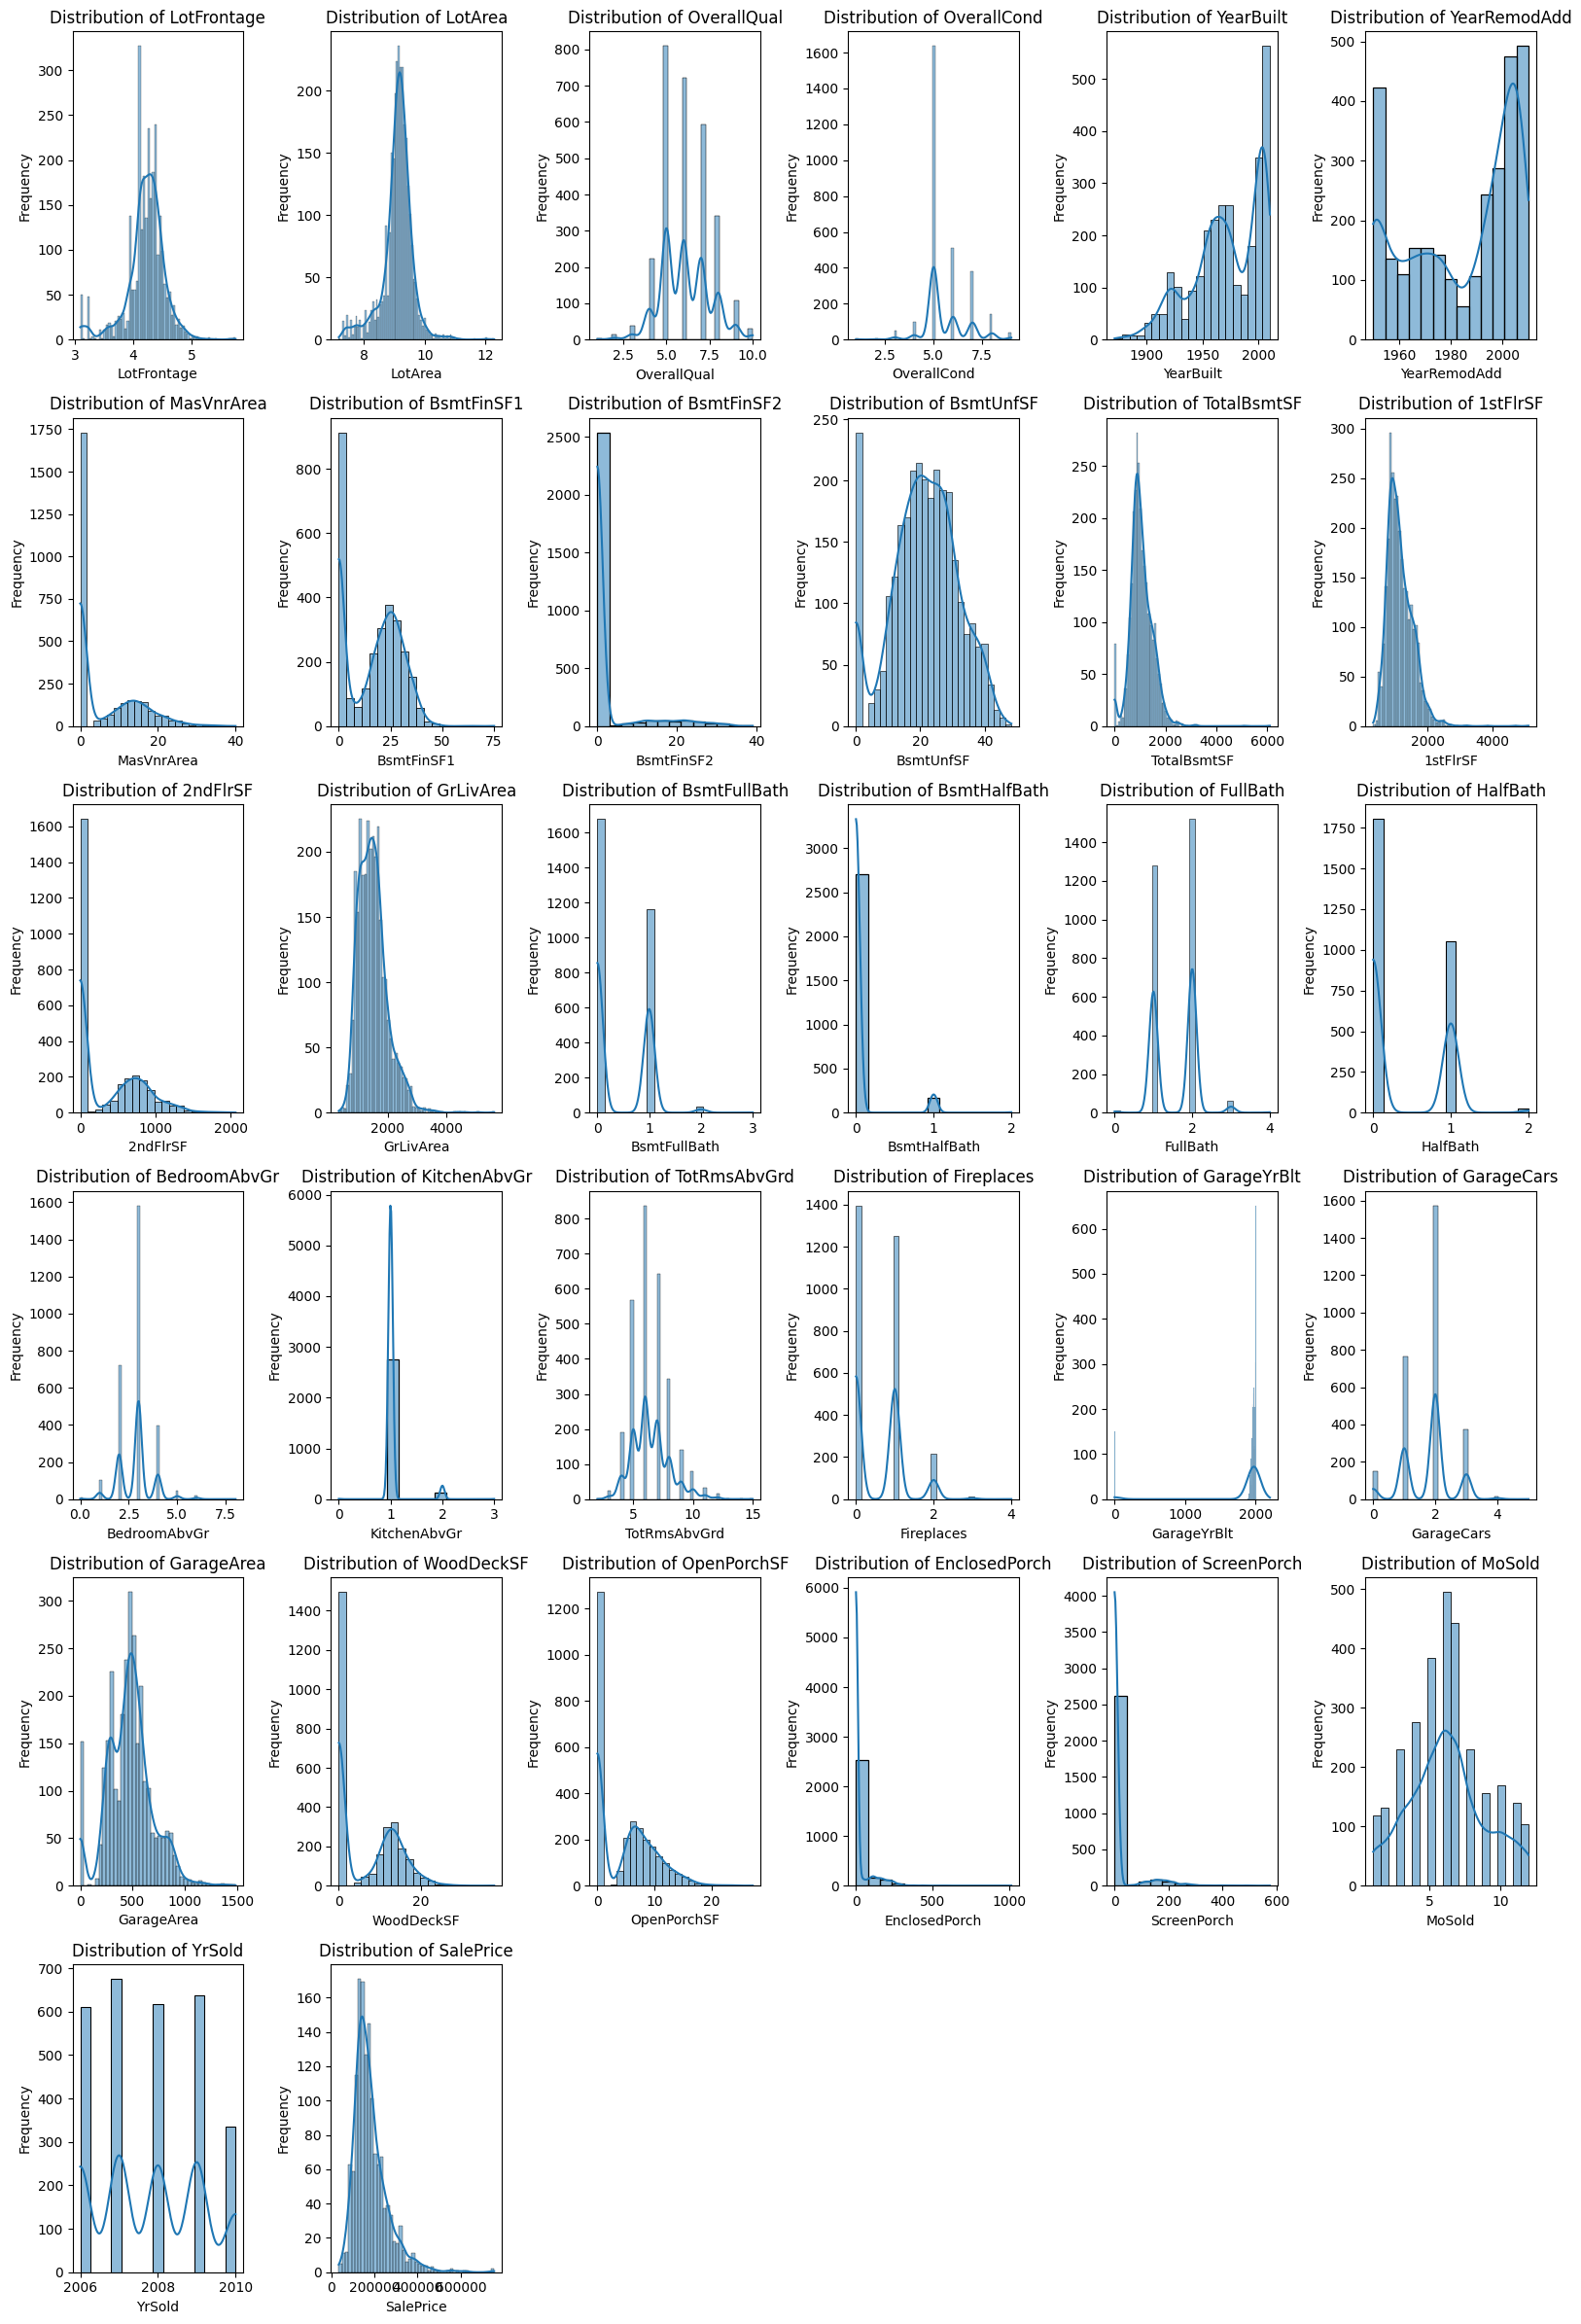

In [38]:
# Selecting numerical columns, excluding 'Id'
numerical_cols = df2_cleaned.loc[:, df2_cleaned.columns != 'Id'].select_dtypes(include=['float64', 'int64']).columns

# Calculating necessary number of rows and columns for subplots
num_vars = len(numerical_cols)
num_cols = int(np.ceil(np.sqrt(num_vars)))  
num_rows = int(np.ceil(num_vars / num_cols))  

# Setting figure size for readable plots
plt.figure(figsize=(16, 4 * num_rows))

# Iterating over numerical columns to create a distribution plot for each
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df2_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjusting layout
plt.tight_layout()

# Displaying plots
plt.show()



In [39]:
analyze_zeros_None(df2_cleaned)

# of Zeros Percentage of Zeros # of None Percentage of None  \
BsmtHalfBath        2706           94.023628         0                0.0   
ScreenPorch         2625           91.209173         0                0.0   
BsmtFinSF2          2537           88.151494         0                0.0   
EnclosedPorch       2436           84.642113         0                0.0   
HalfBath            1803           62.647672         0                0.0   
MasVnrArea          1728           60.041696         0                0.0   
BsmtFullBath        1677           58.269632         0                0.0   
2ndFlrSF            1640           56.984017         0                0.0   
WoodDeckSF          1494           51.911049         0                0.0   
Fireplaces          1395           48.471161         0                0.0   
OpenPorchSF         1270           44.127867         0                0.0   
BsmtFinSF1           912           31.688673         0                0.0   
BsmtUnfSF            239            8.304378         0                0.0   
GarageCars           152            5.281445         0                0.0   
GarageArea           152            5.281445         0                0.0   
GarageYrBlt          151            5.246699         0                0.0   
TotalBsmtSF           79            2.744962         0                0.0   
FullBath              11             0.38221         0                0.0   
BedroomAbvGr           7            0.243224         0                0.0   
KitchenAbvGr           3            0.104239         0                0.0   
Fence                  0                 0.0      2317          80.507297   
MasVnrType             0                 0.0      1730          60.111188   
FireplaceQu            0                 0.0      1395          48.471161   
GarageFinish           0                 0.0       153           5.316192   
GarageQual             0                 0.0       153           5.316192   
GarageType             0                 0.0       151           5.246699   
BsmtCond               0                 0.0        82           2.849201   
BsmtQual               0                 0.0        81           2.814454   
BsmtExposure           0                 0.0        81           2.814454   
BsmtFinType2           0                 0.0        80           2.779708   
BsmtFinType1           0                 0.0        79           2.744962   
MSSubClass             0                 0.0         0                0.0   
MSZoning               0                 0.0         0                0.0   
LotFrontage            0                 0.0         0                0.0   
LotArea                0                 0.0         0                0.0   
LotShape               0                 0.0         0                0.0   
LandContour            0                 0.0         0                0.0   
LotConfig              0                 0.0         0                0.0   
Neighborhood           0                 0.0         0                0.0   
Condition1             0                 0.0         0                0.0   
BldgType               0                 0.0         0                0.0   
HouseStyle             0                 0.0         0                0.0   
OverallQual            0                 0.0         0                0.0   
OverallCond            0                 0.0         0                0.0   
YearBuilt              0                 0.0         0                0.0   
YearRemodAdd           0                 0.0         0                0.0   
RoofStyle              0                 0.0         0                0.0   
Exterior1st            0                 0.0         0                0.0   
Exterior2nd            0                 0.0         0                0.0   
ExterQual              0                 0.0         0                0.0   
ExterCond              0                 0.0         0                0.0   
Foundation

In [40]:
important_var = [ 'Neighborhood', 'GarageCars', 'GarageFinish', 'Foundation']

for col in important_var:
    if col != 'SalePrice':
        print('Variable analysis:', col)
        display(analyze_housing_data(df2_cleaned, col))
        analyze_housing_data(df2_cleaned, col).to_csv(col+'.csv', index=False)
        print('--------------------------------------------------------')


Variable analysis: Neighborhood


Neighborhood  num_houses  avg_sale_price  min_price  percentile1_price  \
0       NoRidge          41   335295.317073   190000.0          202400.00   
1       NridgHt          77   316270.623377   154000.0          167490.00   
2       StoneBr          24   307103.125000   170000.0          172300.00   
3        Timber          37   245078.459459   160000.0          162700.00   
4       Veenker          11   238772.727273   162500.0          162750.00   
5       Somerst          85   225109.858824   144152.0          145704.32   
6       Crawfor          50   212907.220000    90350.0          104756.00   
7       ClearCr          27   210808.592593   130000.0          131152.32   
8       CollgCr         149   198002.456376   110000.0          117060.00   
9       Blmngtn          17   194870.882353   159895.0          159943.80   
10      Gilbert          78   192442.384615   141000.0          144080.00   
11       NWAmes          71   189274.718310    82500.0          119250.00   
12      SawyerW          58   188461.931034    82000.0           91975.00   
13      Mitchel          49   156270.122449    84500.0           88820.00   
14        NAmes         221   145817.162896    87500.0           90580.00   
15        SWISU          23   145555.826087    60000.0           66820.00   
16      NPkVill           9   142694.444444   127500.0          127540.00   
17      Blueste           2   137500.000000   124000.0          124270.00   
18       Sawyer          73   136064.273973    62383.0           75067.24   
19      OldTown         105   128741.514286    37900.0           52980.00   
20      Edwards          97   127680.103093    58500.0           59940.00   
21      BrkSide          51   125752.450980    39300.0           45650.00   
22       BrDale          15   103126.666667    83000.0           83336.00   
23       IDOTRR          32   100177.500000    34900.0           35027.41   
24      MeadowV          17    98576.470588    75000.0           75080.00   

    percentile10_price  percentile25_price  median_price  percentile75_price  \
0             250000.0            265000.0      301500.0            341000.0   
1             202500.0            253293.0      315000.0            374000.0   
2             187950.0            213125.0      276500.0            373731.5   
3             175000.0            187500.0      228950.0            287000.0   
4             165000.0            184250.0      218000.0            282000.0   
5             161800.0            177500.0      225000.0            253000.0   
6             139900.0            160875.0      208812.0            239000.0   
7             150200.0            182500.0      200000.0            240750.0   
8             132900.0            152000.0      197900.0            226000.0   
9             164424.0            174000.0      191000.0            213490.0   
10            167280.0            174000.0      181000.0            194125.0   
11            152000.0            166450.0      182900.0            205000.0   
12            119970.0            148250.0      179950.0            223750.0   
13            118600.0            131000.0      153500.0            171000.0   
14            110000.0            128000.0      140000.0            158000.0   
15            120200.0            132500.0      140000.0            164500.0   
16            127900.0            140000.0      146000.0            148500.0   
17            126700.0            130750.0      137500.0            144250.0   
18            110320.0            127000.0      135000.0            149350.0   
19             87000.0            105900.0      119000.0            140000.0   
20             82300.0            102000.0      123500.0            145000.0   
21             76500.0             94500.0      127500.0            144500.0   
22             86440.0             90500.0      106000.0            115500.0   
23             55000.0             75600.0      107250.0            121750.0   


--------------------------------------------------------
Variable analysis: GarageCars


GarageCars  num_houses  avg_sale_price  min_price  percentile1_price  \
0         3.0         180   309976.722222    81000.0           95690.00   
1         4.0           5   192655.800000   123000.0          124800.00   
2         2.0         803   184432.902864    55993.0           89481.58   
3         1.0         356   128208.589888    35311.0           60000.00   
4         0.0          75   103966.666667    34900.0           37120.00   
5         5.0           0             NaN        NaN                NaN   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            194180.9            246271.0      295246.5           367945.50   
1            141000.0            168000.0      200000.0           206300.00   
2            129000.0            149150.0      178000.0           213125.00   
3             90675.0            110000.0      128350.0           142031.25   
4             60400.0             81500.0      100000.0           127250.00   
5                 NaN                 NaN           NaN                 NaN   

   percentile90_price  percentile99_price  max_price  
0            427115.4           650200.00   755000.0  
1            242107.4           263591.84   265979.0  
2            252935.6           328882.00   430000.0  
3            159717.0           238680.00   266500.0  
4            141000.0           200130.00   200500.0  
5                 NaN                 NaN        NaN

--------------------------------------------------------
Variable analysis: GarageFinish


GarageFinish  num_houses  avg_sale_price  min_price  percentile1_price  \
0          Fin         350   240038.705714    82500.0          110205.00   
1          RFn         413   202222.966102    68400.0          100333.12   
2          Unf         581   142804.364888    35311.0           61906.40   
3         None          75   103966.666667    34900.0           37120.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            148850.0            176000.0      215000.0           284615.75   
1            140000.0            158000.0      190000.0           232000.00   
2             97000.0            117000.0      135000.0           158000.00   
3             60400.0             81500.0      100000.0           127250.00   

   percentile90_price  percentile99_price  max_price  
0            371040.2           584669.76   755000.0  
1            275000.0           429384.40   582933.0  
2            194000.0           314850.40   475000.0  
3            141000.0           200130.00   200500.0

--------------------------------------------------------
Variable analysis: Foundation


Foundation  num_houses  avg_sale_price  min_price  percentile1_price  \
0      PConc         637   225570.436421    78000.0           91484.00   
1       Wood           3   185666.666667   143000.0          143420.00   
2      Stone           6   165959.166667   102776.0          103012.20   
3     CBlock         616   150440.865260    34900.0           60357.45   
4     BrkTil         133   133902.233083    37900.0           44800.00   
5       Slab          24   107365.625000    39300.0           42911.00   

   percentile10_price  percentile25_price  median_price  percentile75_price  \
0            140000.0            173000.0      205000.0           262500.00   
1            147200.0            153500.0      164000.0           207000.00   
2            105138.0            109625.0      126500.0           233734.25   
3            101000.0            123750.0      142312.5           168750.00   
4             79100.0            103600.0      127000.0           153900.00   
5             80950.0             89375.0      104150.0           118884.50   

   percentile90_price  percentile99_price  max_price  
0            330607.2           548880.00   755000.0  
1            232800.0           248280.00   250000.0  
2            266239.5           266473.95   266500.0  
3            207500.0           314475.00   402861.0  
4            195800.0           315400.00   475000.0  
5            143685.9           191715.00   198500.0

--------------------------------------------------------


Conclusions:
-  Houses with 'PConc' foundations are usually pricier, while 'Slab' ones are cheaper. There's a big price range in 'PConc' houses.
- Houses with garages for 3 cars are generally more expensive. Those without a garage are the cheapest, showing that garage capacity positively influences the price.
- A finished garage increases a house’s value. Houses without a garage or with unfinished garages tend to be cheaper.
-  'NoRidge' is an expensive neighborhood with a wide price range, while 'MeadowV' has more affordable and consistently priced options, making price prediction easier in this area.

## Categorical Variables Analysis

En esta parte de análisis de la variables categóricas vamos a trabajar solo con el dataset de entrenamiento (train.csv).

In [41]:
# Select only train data
train_filtered = df2_cleaned[df2_cleaned['Source'] == 'Train']
train_filtered = train_filtered.drop('Source', axis=1)

In [42]:
# Select categorical columns
categorical_columns = train_filtered.select_dtypes(include=['object']).columns

In [43]:
# List to store p-values
p_values = []

# Iterate over each categorical variable and perform ANOVA
for col in categorical_columns:
    groups = [train_filtered['SalePrice'][train_filtered[col] == cat] for cat in train_filtered[col].unique()]
    if len(groups) >= 2:
        f_val, p_val = stats.f_oneway(*groups)
        p_values.append({'Feature': col, 'p-value': p_val})
    else:
        print(f"Variable {col} has categories with only one observation, skipping ANOVA analysis for it")

# Convert results into a DataFrame and sort it
p_values_df = pd.DataFrame(p_values).sort_values(by='p-value')

# Display variables with low p-values (most significant)
print(p_values_df)


          Feature        p-value
5    Neighborhood  1.733260e-217
13      ExterQual  3.437999e-198
16       BsmtQual  9.737189e-189
22    KitchenQual  2.832904e-187
25   GarageFinish  4.246801e-109
23    FireplaceQu  1.586575e-105
15     Foundation   1.461435e-86
24     GarageType   1.513787e-81
0      MSSubClass   4.769008e-75
19   BsmtFinType1   3.987704e-69
21      HeatingQC   6.505103e-67
12     MasVnrType   3.451605e-60
18   BsmtExposure   4.288914e-48
29  SaleCondition   1.507482e-41
10    Exterior1st   8.568756e-41
11    Exterior2nd   1.286922e-40
28       SaleType   3.082429e-39
1        MSZoning   9.612485e-32
2        LotShape   4.288758e-24
26     GarageQual   9.487859e-23
8      HouseStyle   9.975903e-23
9       RoofStyle   9.050478e-17
17       BsmtCond   3.318510e-15
7        BldgType   1.364173e-10
27          Fence   2.224127e-10
20   BsmtFinType2   1.346494e-08
3     LandContour   1.065657e-07
6      Condition1   2.862876e-07
14      ExterCond   2.194696e-06
4       Lo

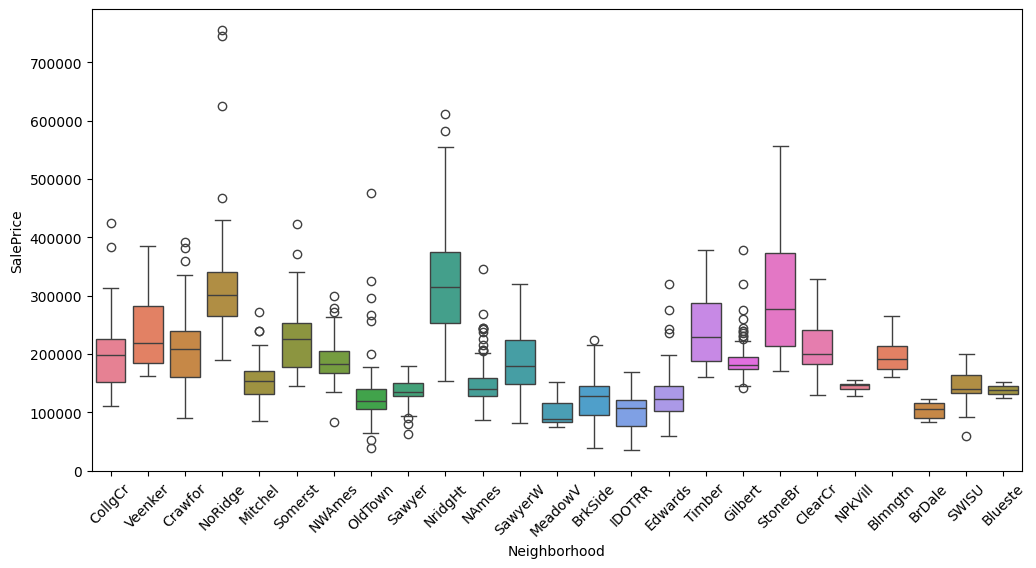

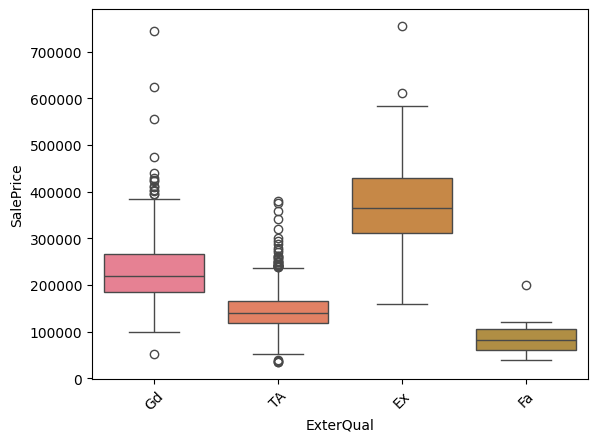

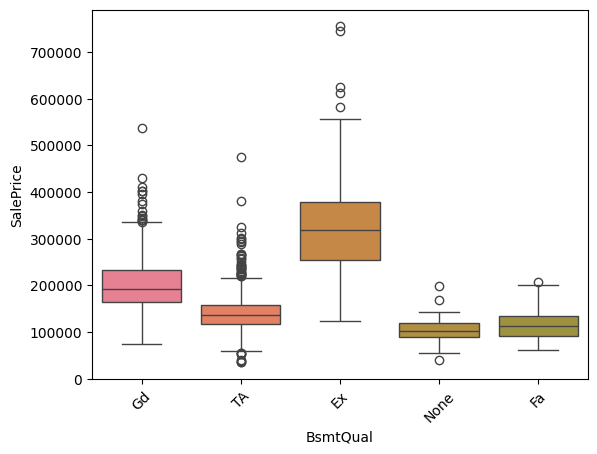

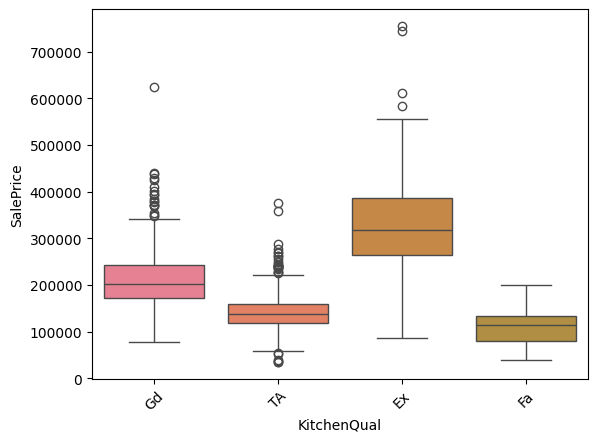

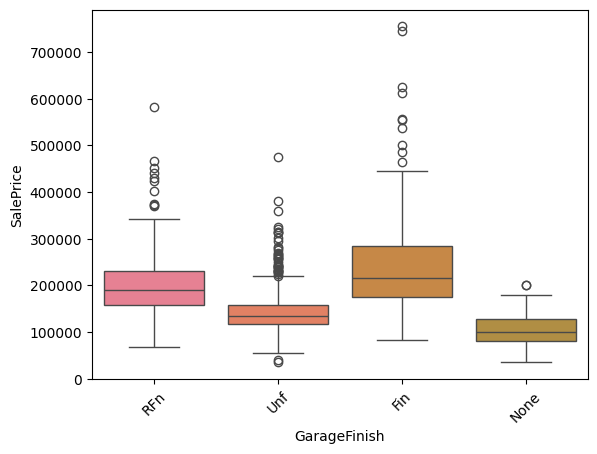

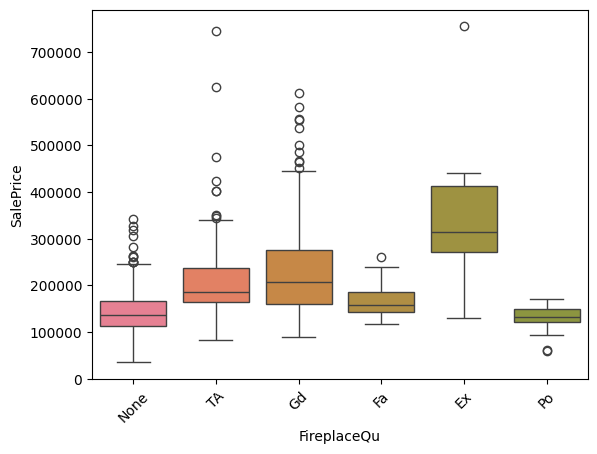

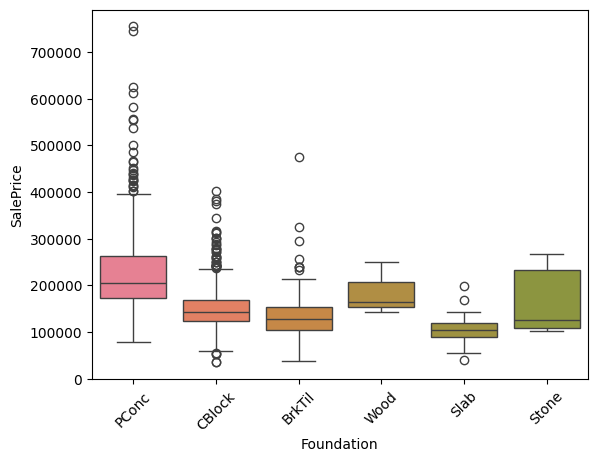

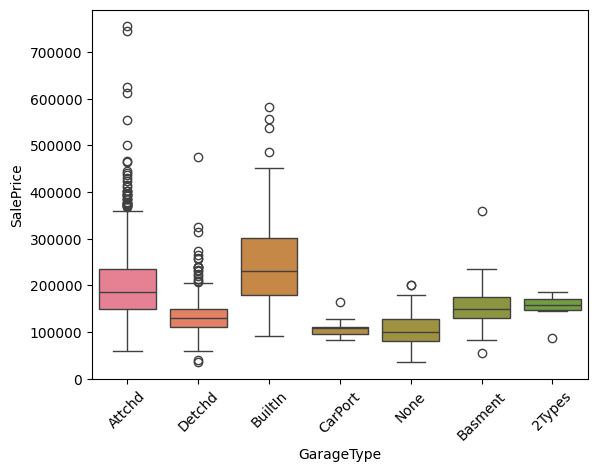

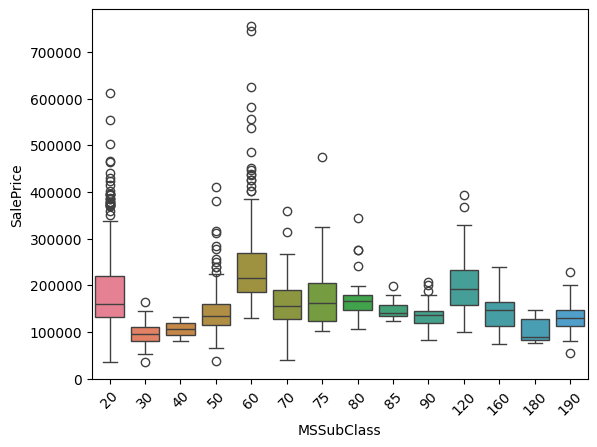

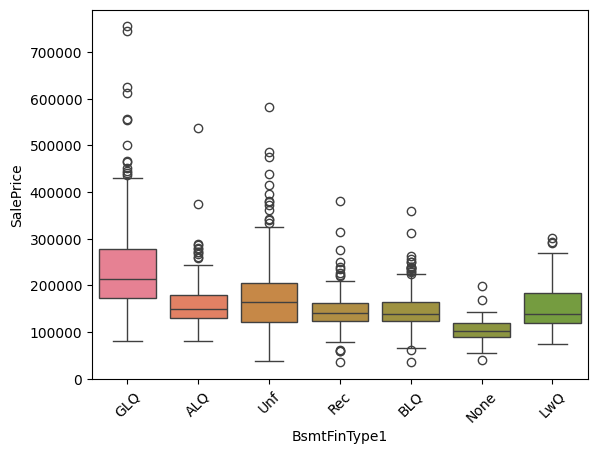

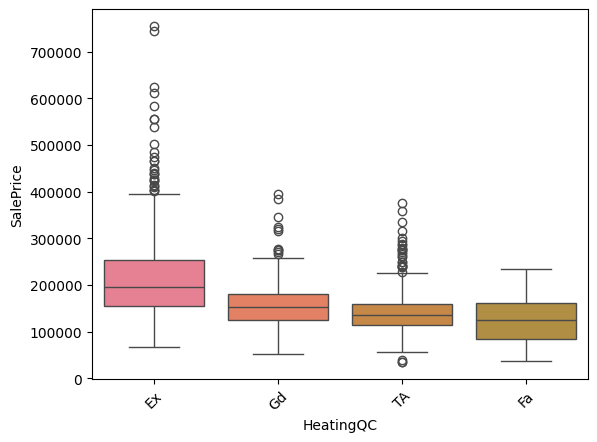

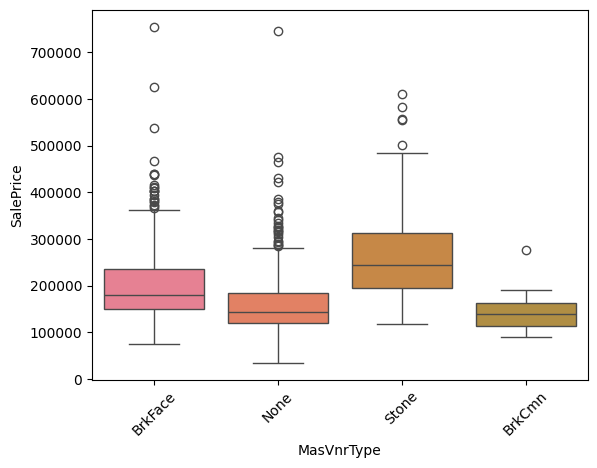

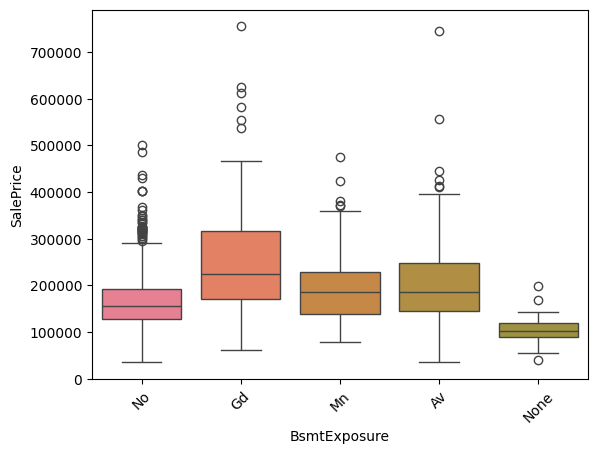

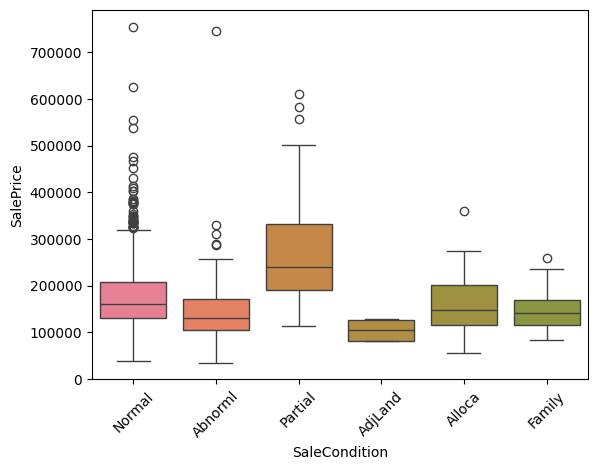

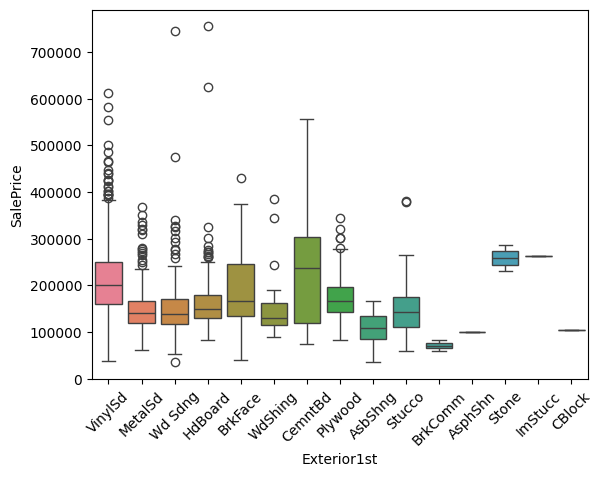

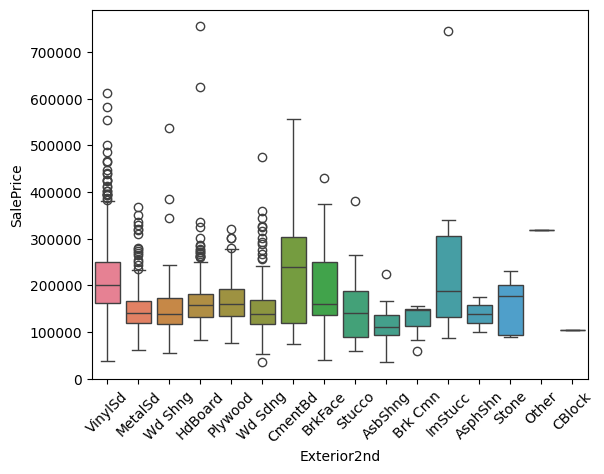

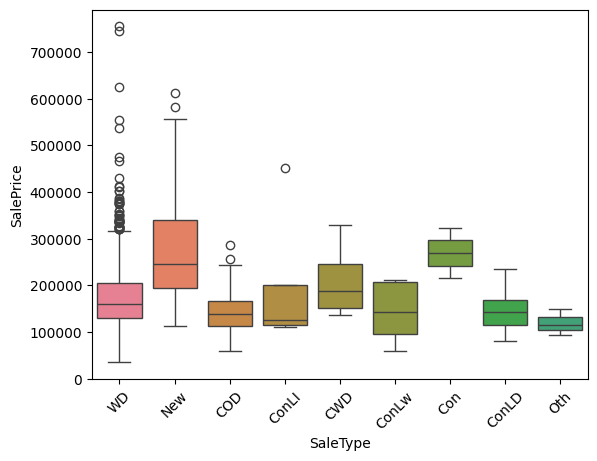

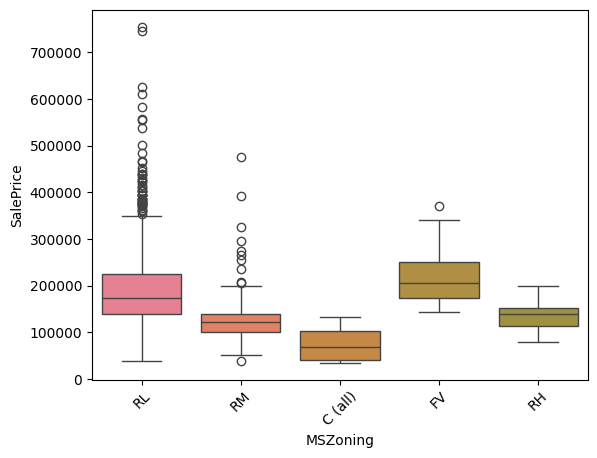

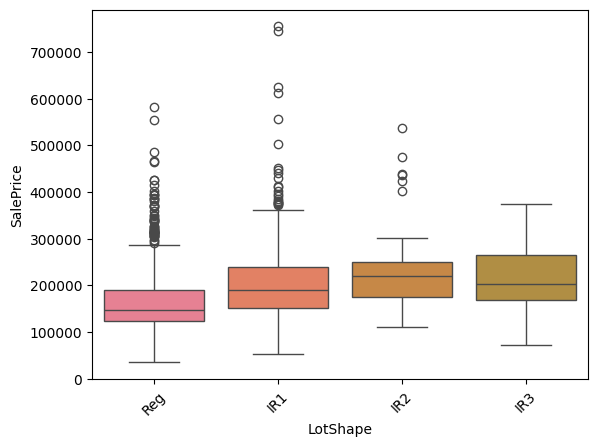

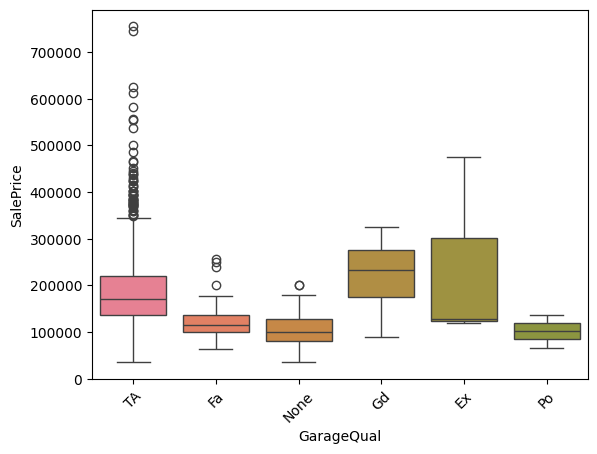

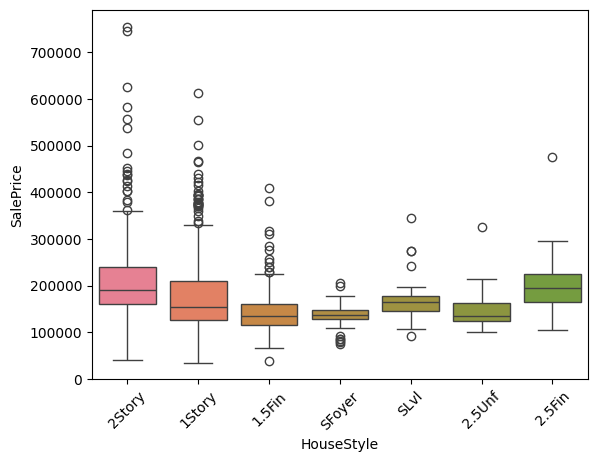

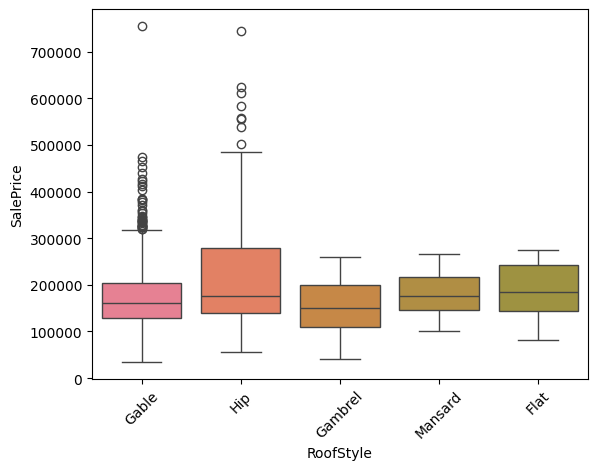

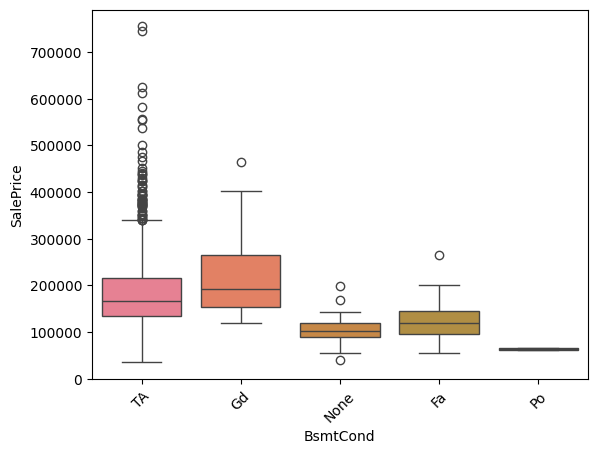

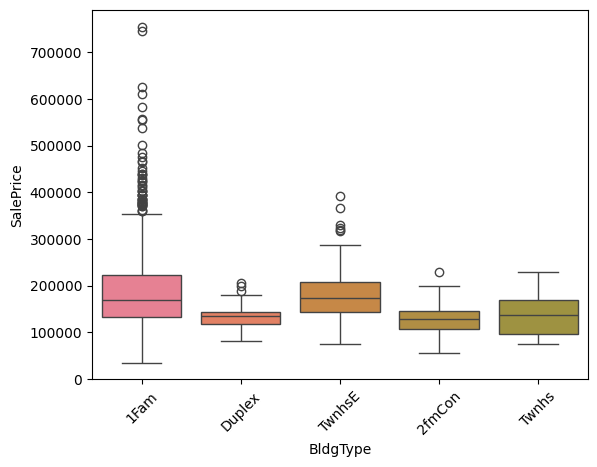

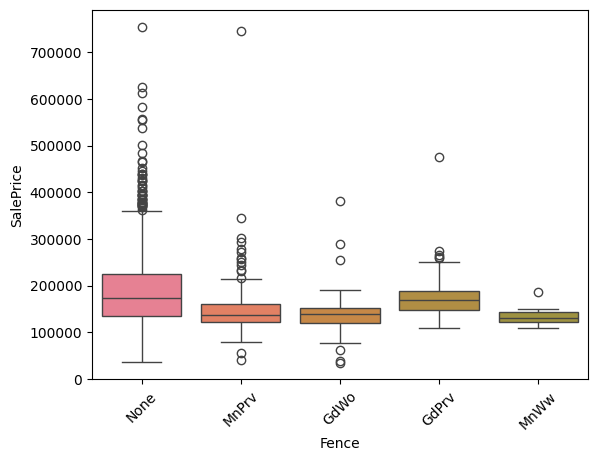

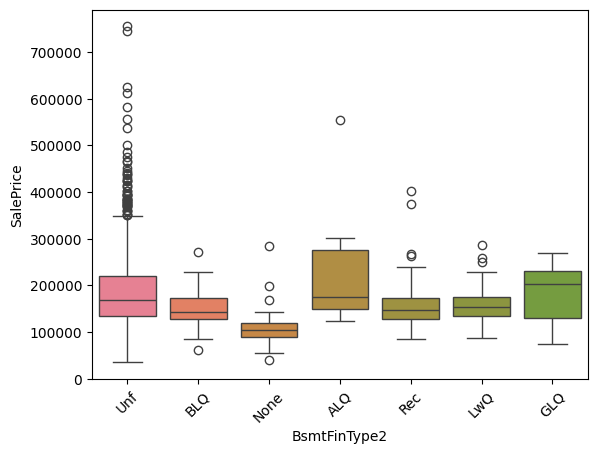

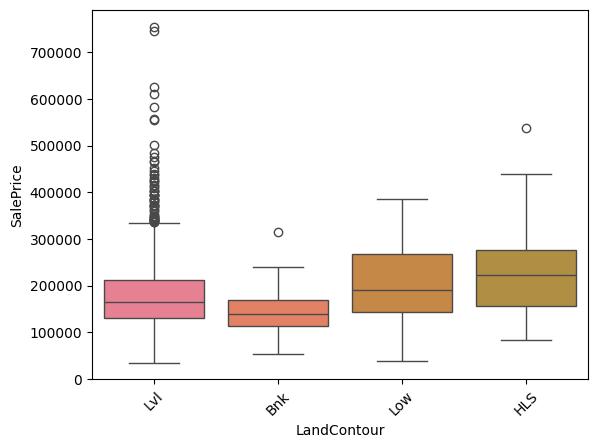

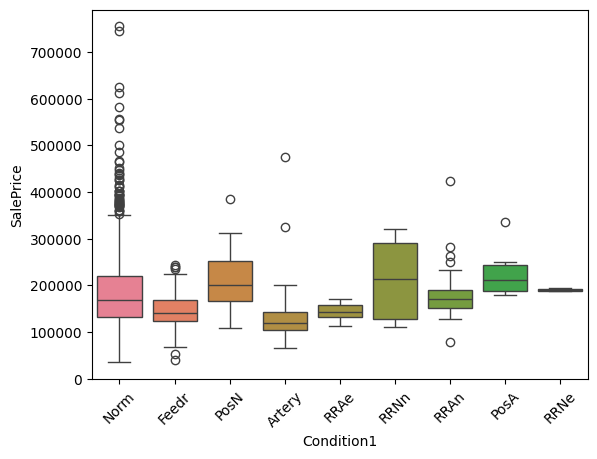

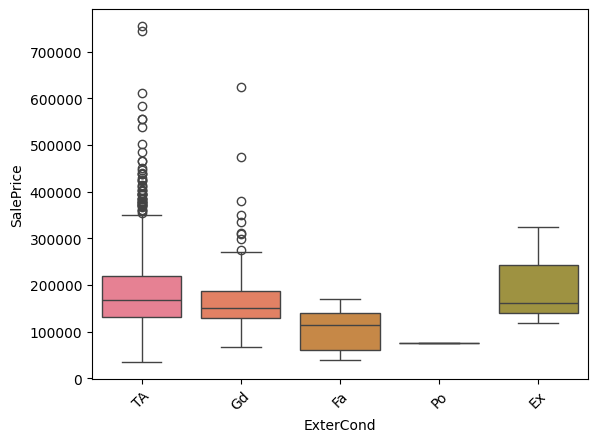

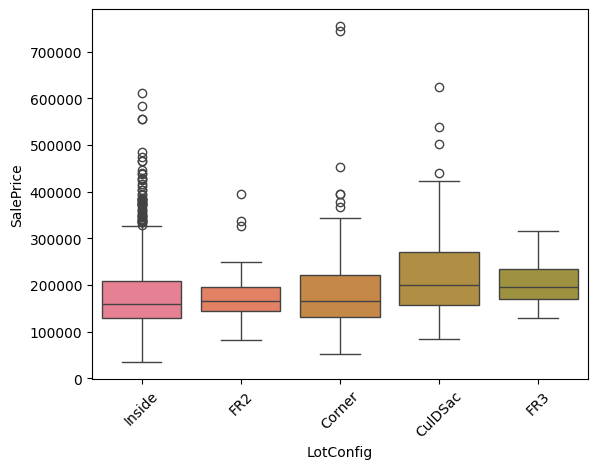

In [44]:
# Visualizing how the most important variables relate to the target variable
categorical_variables = p_values_df['Feature']

plt.figure(figsize=(12, 6))

for col in categorical_variables: 
    sns.boxplot(x= col, y='SalePrice', data=train_filtered, palette=sns.color_palette("husl", 20))
    plt.xticks(rotation=45)
    plt.show()


### Encode Categorical Variables

A la hora de codificar las variables categóricas vamos a usar el conjunto de datos completo (train.csv y test.csv). Vamos a usar solo las variables categoricas selecionadas anteriormente. 

In [45]:
# Creating a copy of df2_cleaned
df3 = df2_cleaned.copy()
# Creating an encoded copy of df3 for further processing
df3_encoded = df3.copy()


In [46]:
# Selecting encoding technique for each variable
label_encoding = ['ExterQual', 'ExterCond', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'HeatingQC', 'LandContour',
                  'BsmtExposure', 'GarageQual', 'BsmtCond', 'LotShape','Fence', 'BsmtFinType1', 'BsmtFinType2' ]
target_encoding = ['Neighborhood', 'MSSubClass','SaleType','Exterior1st','Exterior2nd' ]
OneHot_encoding = ['GarageFinish', 'Foundation', 'GarageType', 'MasVnrType', 'SaleCondition', 'MSZoning',
                  'HouseStyle', 'RoofStyle', 'BldgType', 'Condition1','LotConfig' ]


In [47]:
# Label Encoding
# Using custom mapping dictionaries for encoding

# Mapping for quality-related features
quality_mapping = {
    'Ex': 5,  # Excellent
    'Gd': 4,  # Good
    'TA': 3,  # Average
    'Fa': 2,  # Fair
    'Po': 1,  # Poor
    'None': 0   # None 
}

# Mapping for 'BsmtExposure'
bsmt_exposure_mapping = {
    'Gd': 4,  # Good Exposure
    'Av': 3,  # Average Exposure
    'Mn': 2,  # Minimum Exposure
    'No': 1,  # No Exposure
    'None': 0   # No Basement
}

# Mapping for 'LandContour'
land_contour_mapping = {
    'Lvl': 4,  # Near Flat/Level 
    'Bnk': 3,  # Banked - Quick rise from street grade to building
    'HLS': 2,  # Hillside - Significant slope from side to side
    'Low': 1   # Depression
}

# Mapping for 'LotShape'
lot_shape_mapping = {
    'Reg': 4,  # Regular 
    'IR1': 3,  # Slightly irregular
    'IR2': 2,  # Moderately Irregular
    'IR3': 1   # Irregular
}

# Mapping for 'Fence'
fence_mapping = {
    'GdPrv': 4,  # Good Privacy
    'MnPrv': 3,  # Minimum Privacy
    'GdWo': 2,   # Good Wood
    'MnWw': 1,   # Minimum Wood/Wire
    'None': 0    # No Fence
}

# Mapping for 'BsmtFinType1' and 'BsmtFinType2'
bsmt_fin_type_mapping = {
    'GLQ': 6,  # Good Living Quarters
    'ALQ': 5,  # Average Living Quarters
    'BLQ': 4,  # Below Average Living Quarters
    'Rec': 3,  # Average Rec Room
    'LwQ': 2,  # Low Quality
    'Unf': 1,  # Unfinished
    'None': 0  # No Basement
}

# Apply mappings to respective columns
df3_encoded['BsmtExposure'] = df3_encoded['BsmtExposure'].replace(bsmt_exposure_mapping)
df3_encoded['LandContour'] = df3_encoded['LandContour'].replace(land_contour_mapping)
df3_encoded['Fence'] = df3_encoded['Fence'].replace(fence_mapping)
df3_encoded['LotShape'] = df3_encoded['LotShape'].replace(lot_shape_mapping)
df3_encoded['BsmtFinType1'] = df3_encoded['BsmtFinType1'].replace(bsmt_fin_type_mapping)
df3_encoded['BsmtFinType2'] = df3_encoded['BsmtFinType2'].replace(bsmt_fin_type_mapping)

# Apply quality mapping to other columns not covered by specific mappings
for col in label_encoding:
    if col not in ['BsmtExposure','Fence', 'LotShape', 'BsmtFinType1','BsmtFinType2', 'LandContour' ]:
        df3_encoded[col] = df3_encoded[col].replace(quality_mapping)


In [48]:
# Target Encoding
# Create a Target Encoder
encoder = ce.TargetEncoder()

# Fit the encoder with the categorical variables and target
encoder.fit(df3[df3['Source'] == 'Train'][target_encoding], df3[df3['Source'] == 'Train']['SalePrice'])

# Transform the categorical variables
target_encoded = encoder.transform(df3_encoded[target_encoding])

# Replace the original columns in df3 with the encoded ones
for col in target_encoding:
    df3_encoded[col] = target_encoded[col]


In [49]:
# One-Hot Encoding

# Applying One-Hot Encoding with get_dummies
df3_encoded = pd.get_dummies(df3_encoded, columns=OneHot_encoding, prefix=OneHot_encoding)

# Convert boolean variables to int
for col in df3_encoded.select_dtypes(include=['bool']).columns:    
    df3_encoded[col] = df3_encoded[col].astype(int, errors='ignore')


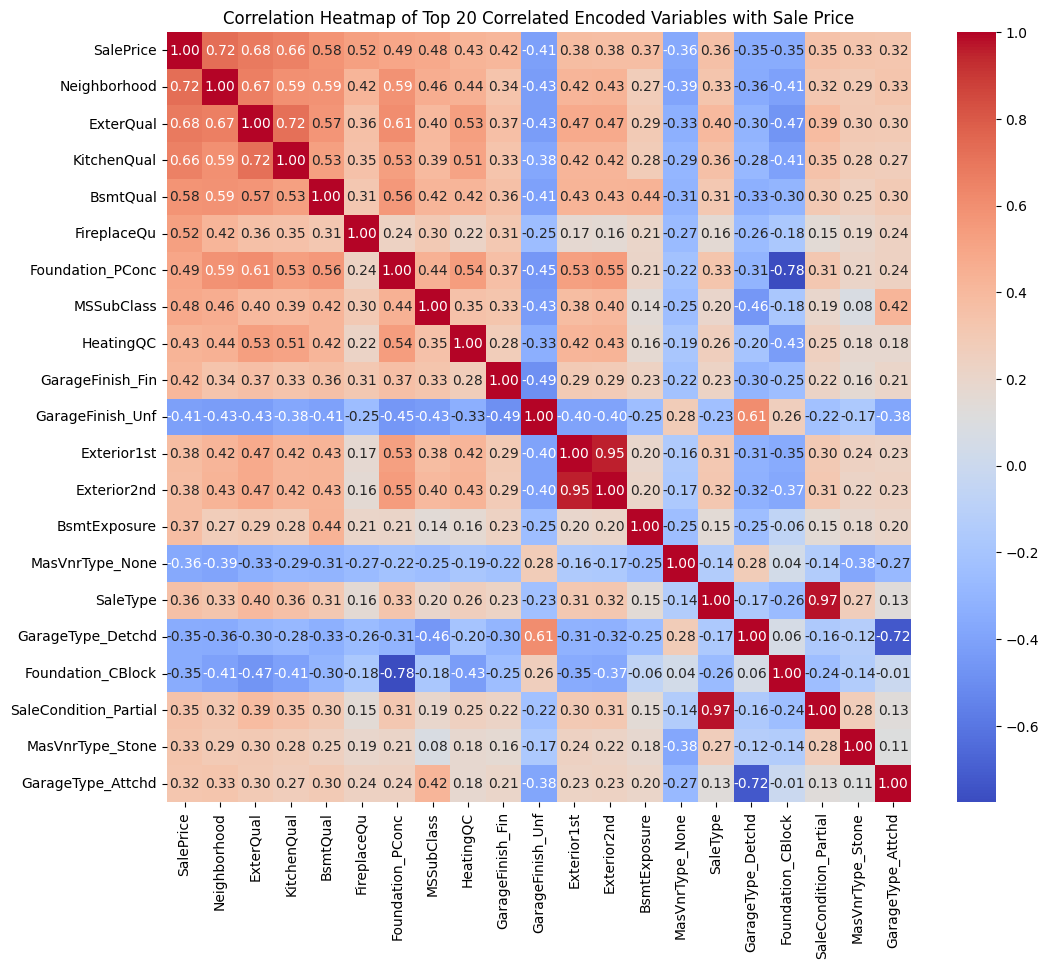

In [50]:
# Plot heatmap to visualize the correlation between Sale Price and high correlated encoded variables

# Getting the names of One-Hot encoded variables after encoding
original_onehot_vars = OneHot_encoding
onehot_encoded_vars = [col for col in df3_encoded.columns if any(original_var in col for original_var in original_onehot_vars)]

# select all encoded variables 
encoded_vars = label_encoding + target_encoding + onehot_encoded_vars

# Calculating the correlation of each encoded variable with the Sale Price
correlations_with_target = df3_encoded[['SalePrice'] + encoded_vars ].corr()['SalePrice'].drop('SalePrice')

# Identifying the top 20 variables that have the highest absolute correlation with the Sale Price
top_corr_vars = correlations_with_target.abs().sort_values(ascending=False).head(20).index

# Preparing the list of selected variables for the heatmap
selected_vars = ['SalePrice'] + list(top_corr_vars)

# Calculating the correlation matrix for the selected variables
selected_corr_matrix = df3_encoded[selected_vars].corr()

# Plotting a heatmap to visualize the correlation between Sale Price and the top 20 correlated encoded variables
plt.figure(figsize=(12, 10))
sns.heatmap(selected_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Top 20 Correlated Encoded Variables with Sale Price')
plt.show()

### Feature Engineering

In [51]:
# Creating a new DataFrame for new features
new_features_df = pd.DataFrame()
# Creating a copy of df3
df4 = df3.copy()


In [52]:
# Creating new feature 'AllFlrSF' by summing 'GrLivArea' and 'TotalBsmtSF'
new_features_df['AllFlrSF'] = df3['GrLivArea'] + df3['TotalBsmtSF']
# Creating new feature 'TotalBaths' by summing all types of bathrooms
new_features_df['TotalBaths'] = (df3['FullBath'] + 0.5*df3['HalfBath'] + 
                     df3['BsmtFullBath'] + 0.5*df3['BsmtHalfBath'])


In [53]:
# Create AvgQuality: average of the quality columns
quality_columns = ['ExterQual', 'BsmtQual', 'KitchenQual','FireplaceQu','HeatingQC','OverallQual', 'GarageQual']

# Initialize a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform selected quality columns
df4[quality_columns] = scaler.fit_transform(df3_encoded[quality_columns])

# Calculate the average of the quality columns for each row
new_features_df['AvgQuality'] = df4[quality_columns].mean(axis=1)

df4[quality_columns] = df3[quality_columns]


In [54]:
# Show new features
new_features_df.head()

AllFlrSF  TotalBaths  AvgQuality
0    2566.0         3.5    0.628571
1    2524.0         2.5    0.603175
2    2706.0         3.5    0.714286
3    2473.0         2.0    0.630952
4    3343.0         3.5    0.730159

In [55]:
# Create a dataframe with new features and encoded variable
df4_encoded = pd.concat([df3_encoded, new_features_df], axis=1)
df4 = pd.concat([df4, new_features_df], axis=1)

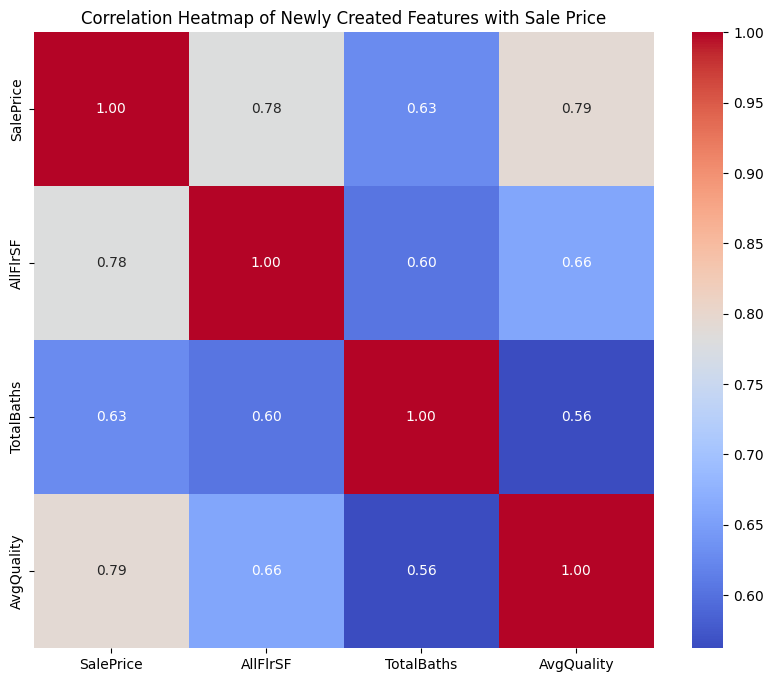

In [56]:
# Visualize the correlation between Sale Price and the newly engineered features.

# List of newly created features
new_features = ['AllFlrSF', 'TotalBaths', 'AvgQuality']

# Adding 'SalePrice' to the list to compute correlations with the target variable
selected_vars = ['SalePrice'] + new_features

# Computing the correlation matrix for the selected variables
selected_corr_matrix = df4_encoded[selected_vars].corr()

# Drawing a heatmap to visualize correlations between newly created features and Sale Price
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Newly Created Features with Sale Price')
plt.show()


### Scaling 

In [57]:
# Creating a copy of the df4_encoded DataFrame and assigning it to df5
df5 = df4_encoded.copy()

In [58]:
# Selecting the numeric columns from df5
numeric_cols = df5.select_dtypes(include=['float64', 'int64'])

# Creating a list of columns to scale, excluding 'Id' and 'SalePrice'
cols_to_scale = [col for col in numeric_cols if col not in ['Id', 'SalePrice']]

# Initializing the StandardScaler
scaler = StandardScaler()

# Applying the scaler to all numeric variables in the specified columns
df5[cols_to_scale] = scaler.fit_transform(df5[cols_to_scale])

# Display the first few rows of the scaled DataFrame
df5.head()


Id  MSSubClass  LotFrontage   LotArea  LotShape  LandContour  Neighborhood  \
0   1    1.553634    -0.071903 -0.105311  0.705624      0.30751      0.320634   
1   2    0.070757     0.545456  0.144533  0.705624      0.30751      0.328639   
2   3    1.553634     0.062098  0.455098 -1.043546      0.30751      0.320634   
3   4   -0.409293    -0.309390  0.134308 -1.043546      0.30751      0.571970   
4   5    1.553634     0.690763  0.919354 -1.043546      0.30751      2.575345   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd  Exterior1st  \
0     0.639896    -0.503957   1.037927      0.891252     1.093062   
1    -0.068692     2.195278   0.142815     -0.405330    -1.117181   
2     0.639896    -0.503957   0.971622      0.843230     1.093062   
3     0.639896    -0.503957  -1.879474     -0.693459    -1.045055   
4     1.348485    -0.503957   0.938470      0.747187     1.093062   

   Exterior2nd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  \
0     1.125205    0.984462   1.032195  -0.232121  0.568563  0.141933   
1    -1.112211   -0.728838  -0.687931  -0.232121  0.568563  0.141933   
2     1.125205    0.828787   1.032195  -0.232121  0.568563  0.141933   
3    -0.629473   -0.728838  -0.687931  -0.232121 -0.531857  1.872799   
4     1.125205    1.560655   1.032195  -0.232121  0.568563  0.141933   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0     -0.585939      1.159712    0.769686      -0.28608   -0.339202   
1      2.210632      0.686354    1.127032      -0.28608   -0.339202   
2      0.346251      1.159712    0.425796      -0.28608   -0.339202   
3     -0.585939      0.686354   -0.132639      -0.28608   -0.339202   
4      1.278442      1.159712    0.695387      -0.28608   -0.339202   

   BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  2ndFlrSF  GrLivArea  \
0  -0.864386    -0.445805   0.883491 -0.777364  1.203345   0.409056   
1  -0.422307     0.471298   0.883491  0.254330 -0.787586  -0.477095   
2  -0.040181    -0.301237   0.883491 -0.614732  1.231320   0.559385   
3   0.190729    -0.671692  -0.162022 -0.510546  0.974877   0.422902   
4   0.084938     0.207010   0.883491 -0.042981  1.667273   1.374327   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0      1.083605     -0.249257  0.775077  1.232187      0.163264     -0.206523   
1     -0.822639      3.826658  0.775077 -0.760079      0.163264     -0.206523   
2      1.083605     -0.249257  0.775077  1.232187      0.163264     -0.206523   
3      1.083605     -0.249257 -1.037004 -0.760079      0.163264     -0.206523   
4      1.083605     -0.249257  0.775077  1.232187      1.380558     -0.206523   

   KitchenQual  TotRmsAbvGrd  Fireplaces  FireplaceQu  GarageYrBlt  \
0     0.733804      0.983527   -0.926880    -0.981911     0.290825   
1    -0.775766     -0.293527    0.618636     0.679104     0.229711   
2     0.733804     -0.293527    0.618636     0.679104     0.286298   
3     0.733804      0.345000    0.618636     1.232775     0.279508   
4     0.733804      1.622054    0.618636     0.679104     0.284035   

   GarageCars  GarageArea  ...  SaleCondition_Partial  MSZoning_C (all)  \
0    0.300946    0.344278  ...                      0                 0   
1    0.300946   -0.065132  ...                      0                 0   
2    0.300946    0.623420  ...                      0                 0   
3    1.615246    0.781601  ...                      0                 0   
4    1.615246    1.684162  ...                      0                 0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  HouseStyle_1.5Fin  \
0            0            0            1            0                  0   
1            0            0            1            0                  0   
2            0            0            1            0                  0   
3            0            0            1            0                  0   
4            0            0            1            0                  0   

### Model Selection 

- Ridge Regression: Scaling with Z-Score
- Lasso Regression: Scaling with Z-Score
- XGBoost: No scaling
- Categorical Boosting Regressor: No encoding, no scaling

#### Ridge and Lasso Regression

In [59]:
# Filter the training data
train_data_1 = df5[df5['Source'] == 'Train'].drop(columns=['Id', 'Source'])

# Select features and target variable
X1 = train_data_1.drop(columns=['SalePrice'])
y1 = train_data_1['SalePrice']

# Split the dataset into training and testing sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [60]:
# Define the parameters for GridSearchCV
params_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
params_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Hyperparameter optimization and training for Ridge
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_1, y_train_1)
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_1)
mse_ridge = mean_squared_error(y_test_1, y_pred_ridge)

# Hyperparameter optimization and training for Lasso
lasso = Lasso()
grid_lasso = GridSearchCV(lasso, params_lasso, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train_1, y_train_1)
best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_1)
mse_lasso = mean_squared_error(y_test_1, y_pred_lasso)

# Print results
print(f"Best Ridge Model: {best_ridge}, MSE: {mse_ridge}")
print(f"Best Lasso Model: {best_lasso}, MSE: {mse_lasso}")


Best Ridge Model: Ridge(alpha=100), MSE: 597876395.7196556
Best Lasso Model: Lasso(alpha=100), MSE: 627849746.451177


#### XGBoost Regressor

In [61]:
# Filter training data
train_data_2 = df4_encoded[df4_encoded['Source'] == 'Train'].drop(columns=['Id', 'Source'])

# Select features and target variable
X2 = train_data_2.drop(columns=['SalePrice'])
y2 = train_data_2['SalePrice']

# Split the dataset into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [62]:
# Define parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,  
    'learning_rate': 0.01,  
    'n_estimators': 3000,  
    'min_child_weight': 1,  
    'colsample_bytree': 0.5,  
    'subsample': 0.3, 
    'reg_alpha': 7,
    'reg_lambda': 0.001,
    'num_parallel_tree': 1,
}

# Optimize and train the XGBoost model
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train_2, y_train_2)

predictions_xgb = model_xgb.predict(X_test_2)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_2, predictions_xgb))
print(f"Root Mean Square Error: {rmse}")

mae = mean_absolute_error(y_test_2, predictions_xgb)
print(f"Mean Absolute Error: {mae}")

rmsle = np.sqrt(mean_squared_log_error(y_test_2, predictions_xgb))
print(f"Root Mean Squared Log Error: {rmsle}")


Root Mean Square Error: 18568.030790681638
Mean Absolute Error: 13520.405548525529
Root Mean Squared Log Error: 0.10985549778946796


#### Categorical Boost Regressor

In [63]:
# Filter training data
train_data_3 = df4[df4['Source'] == 'Train'].drop(columns=['Id', 'Source'])

# Select features and target variable
X3 = train_data_3.drop(columns=['SalePrice'])
y3 = train_data_3['SalePrice']

# Split the dataset into training and test sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.2, random_state=42)


In [64]:
# CatBoost parameters
catboost_params = dict(
    iterations=9000,
    depth=7,
    learning_rate=0.01,
    loss_function='RMSE',
    random_seed=42,
    logging_level='Silent',
    l2_leaf_reg=0.5, 
    thread_count=-1
)

# Initialize the CatBoost model
model_catboost = CatBoostRegressor(**catboost_params)

# Select the index of categorical variables
index_categorical_feature = [i for i, col in enumerate(X_train_3.columns) if X_train_3[col].dtype == 'object']

# Train the model
model_catboost.fit(
    X_train_3, y_train_3,
    cat_features=index_categorical_feature,
    eval_set=(X_test_3, y_test_3)
)

# Make predictions
predictions_catboost = model_catboost.predict(X_test_3)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_3, predictions_catboost))
print(f"Mean Square Error: {rmse}")

mae = mean_absolute_error(y_test_3, predictions_catboost)
print(f"Mean Absolute Error: {mae}")

rmsle = np.sqrt(mean_squared_log_error(y_test_3, predictions_catboost))
print(f"The score is: {rmsle}")


Mean Square Error: 18542.65291900754
Mean Absolute Error: 13773.281372947598
The score is: 0.11699336791028378


Based on our model selection phase, **CatBoostRegressor** emerged as the top performer for predicting house prices, showing a good balance between accuracy and handling of categorical variables effectively. With a solid RMSE of **18,542.65** and MAE of **13,773.28**, it stands competitively against the other models tested. Hence, we will proceed with **CatBoostRegressor** for making final predictions on our test dataset.

In [65]:
# Filter the final training data
train_data_final = df4[df4['Source'] == 'Train'].drop(columns=['Id', 'Source'])

# Split the data into features (X) and target variable (y)
X = train_data_final.drop(columns=['SalePrice'])
y = train_data_final['SalePrice']

# Get the test IDs
test_id = df4[df4['Source'] == 'Test']['Id']

# Prepare the test data
test_data = df4[df4['Source'] == 'Test'].drop(columns=['Id', 'Source', 'SalePrice'])

# Identify categorical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor model
model_catboost = CatBoostRegressor(**catboost_params)

# Train the model with categorical features
model_catboost.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

# Make predictions on the test data
predictions_catboost = model_catboost.predict(test_data)



In [66]:
# make a dataframe and save it as a csv for submission
submission_df = pd.DataFrame({'Id': test_id, 'SalePrice': predictions_catboost})
submission_df.to_csv('submission.csv', index=False)

# print dataframe
submission_df


Id      SalePrice
1419  1461  114664.992731
1420  1462  158077.058175
1421  1463  190079.563055
1422  1464  198712.373459
1423  1465  183352.645761
...    ...            ...
2873  2915   78541.576646
2874  2916   84105.782445
2875  2917  157500.568677
2876  2918  115206.725664
2877  2919  210233.236277

[1459 rows x 2 columns]